# Customer 360 - Project Context

This Customer‑360 extends our earlier work—same cleaned data foundation, now focused on retention & personalization to fix the leaky bucket. 

**Findings from previous analysis:**
- Stagnation (–1.2% YoY in 2011)
- 37% new vs 37% lost customers 
-  Rvenue dependence on loyalists (~44% of base → ~88% of revenue)

The focus is on:
- Identifying which customers are **most valuable** and protecting them.
- Predicting which customers are **at risk of churn** and intervening early.
- Designing a **personalized recommendation strategy** to drive revenue, cross-sell for stickiness, and reactivate churned customers.

We address these questions in four phases:

1. **Segmentation & Impact Analysis**  
   - RFM-style segmentation (Champions, Loyal, Potential Loyalists, At Risk, Lost).  
   - Revenue and activity contribution per segment.

2. **Churn Prediction**  
   - Machine learning models (Logistic Regression, Random Forest, XGBoost).  
   - Identify customers with high churn probability within a 90-day window.

3. **Product Stickiness & Retention Analysis**  
   - Category-level retention, cross-sell patterns, and CLV impact.  
   - Identify categories that act as **revenue drivers** vs **retention anchors**.

4. **Recommendation System**  
   - Three personalized scenarios:
     - Drive Revenue: recommend top-selling items in favorite category.
     - Cross-Sell Stickiness: recommend products from related categories.
     - Churn Reactivation: recommend sticky-category products with offers.

# Project Setup

In [134]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Time series and forecasting libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")


All libraries imported successfully!


In [135]:
# Load the cleaned retail transaction data
df = pd.read_csv('datasets/retail_transaction_data_clean.csv')

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['order_date'].min()} to {df['order_date'].max()}")
print(f"Number of unique customers: {df['customer_id'].nunique()}")
print(f"Number of unique products: {df['product_id'].nunique()}")
print(f"Total revenue: ${df['total_amount'].sum():,.2f}")

df.head()


Dataset shape: (757349, 15)
Date range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00
Number of unique customers: 5819
Number of unique products: 4604
Total revenue: $14,891,236.64


,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country,total_amount,year,month,quarter,day_of_week,month_year,product_category
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009,12,4,Tuesday,2009-12,CHRISTMAS_HOLIDAY
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,4,Tuesday,2009-12,BEAUTY_PERSONAL
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,4,Tuesday,2009-12,BEAUTY_PERSONAL
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009,12,4,Tuesday,2009-12,HOME_DECOR
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009,12,4,Tuesday,2009-12,FURNITURE_STORAGE


We have cleaned the dataset in the separate analysis, so we expect this dataset doesn't need extensive preprocessing anymore

In [136]:
# Data Quality Assessment
print("\n1. Missing Values:")
print(df.isnull().sum())

print("\n2. Data Types:")
print(df.dtypes)

print("\n3. Duplicate Records:")
print(f"Total duplicates: {df.duplicated().sum()}")

print("\n4. Customer ID Analysis:")
print(f"Missing customer IDs: {df['customer_id'].isnull().sum()}")
print(f"Customer ID data type: {df['customer_id'].dtype}")

# Check for any data anomalies
print("\n5. Data Anomalies:")
print(f"Negative quantities: {(df['quantity'] < 0).sum()}")
print(f"Negative unit prices: {(df['unit_price'] < 0).sum()}")
print(f"Negative total amounts: {(df['total_amount'] < 0).sum()}")

# Display basic statistics
print("\n6. Basic Statistics:")
df.describe()



1. Missing Values:
order_id               0
product_id             0
product_description    0
quantity               0
order_date             0
unit_price             0
customer_id            0
country                0
total_amount           0
year                   0
month                  0
quarter                0
day_of_week            0
month_year             0
product_category       0
dtype: int64

2. Data Types:
order_id                 int64
product_id              object
product_description     object
quantity                 int64
order_date              object
unit_price             float64
customer_id            float64
country                 object
total_amount           float64
year                     int64
month                    int64
quarter                  int64
day_of_week             object
month_year              object
product_category        object
dtype: object

3. Duplicate Records:
Total duplicates: 24766

4. Customer ID Analysis:
Missing customer IDs: 0


,order_id,quantity,unit_price,customer_id,total_amount,year,month,quarter
count,757349.000000,757349.000000,757349.000000,757349.00000,757349.000000,757349.000000,757349.000000,757349.000000
mean,537562.650369,12.337442,2.861636,15347.90287,19.662318,2010.424951,7.528010,2.828522
std,26713.192113,70.291119,3.927546,1692.70848,60.383443,0.565893,3.443772,1.133337
min,489434.000000,1.000000,0.030000,12346.00000,0.060000,2009.000000,1.000000,1.000000
25%,515100.000000,2.000000,1.250000,13999.00000,4.350000,2010.000000,5.000000,2.000000
50%,537050.000000,5.000000,1.950000,15301.00000,10.500000,2010.000000,8.000000,3.000000
75%,561894.000000,12.000000,3.750000,16814.00000,17.850000,2011.000000,11.000000,4.000000
max,581587.000000,19152.000000,295.000000,18287.00000,8925.000000,2011.000000,12.000000,4.000000


# Phase 1: Creating a single customer view aggregation

In this phase, we will create an aggregated table in customer level for our transaction data, the goal is to get the clear metric that reflect the behavior and quality of our customer.

In [137]:
# Data Preprocessing for Customer 360
print("=== DATA PREPROCESSING ===")

# Convert order_date to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Remove rows with missing customer_id (necessary for customer analysis)
print(f"Rows before removing missing customer_ids: {len(df)}")
df_clean = df.dropna(subset=['customer_id']).copy()
print(f"Rows after removing missing customer_ids: {len(df_clean)}")

# Create additional features for customer analysis
df_clean['order_year'] = df_clean['order_date'].dt.year
df_clean['order_month'] = df_clean['order_date'].dt.month
df_clean['order_weekday'] = df_clean['order_date'].dt.day_name()

print(f"\nFinal dataset shape: {df_clean.shape}")
print(f"Date range: {df_clean['order_date'].min()} to {df_clean['order_date'].max()}")
print(f"Analysis period: {(df_clean['order_date'].max() - df_clean['order_date'].min()).days} days")

=== DATA PREPROCESSING ===
Rows before removing missing customer_ids: 757349
Rows after removing missing customer_ids: 757349

Final dataset shape: (757349, 18)
Date range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00
Analysis period: 738 days


In [138]:
# Customer-Level Aggregations - Foundation for Customer 360
print("CUSTOMER LEVEL AGGREGATIONS")

df_clean

# Calculate customer metrics
customer_metrics = df_clean.groupby('customer_id').agg({
    'order_id': 'nunique',  # Number of orders
    'order_date': ['min', 'max'],  # First and last purchase dates
    'total_amount': ['sum', 'mean', 'count'],  # Total spent, average order value, transaction count
    'quantity': 'sum',  # Total items purchased
    'product_id': 'nunique',  # Number of unique products
}).reset_index()

# Flatten column names
customer_metrics.columns = [
    'customer_id', 'total_orders', 'first_purchase', 'last_purchase',
    'total_spent', 'avg_order_value', 'total_transactions', 'total_quantity',
    'unique_products'
]

# Calculate additional customer features
reference_date = df_clean['order_date'].max()
customer_metrics['days_since_first_purchase'] = (reference_date - customer_metrics['first_purchase']).dt.days
customer_metrics['days_since_last_purchase'] = (reference_date - customer_metrics['last_purchase']).dt.days
customer_metrics['customer_lifespan_days'] = (customer_metrics['last_purchase'] - customer_metrics['first_purchase']).dt.days

# Calculate frequency metrics
customer_metrics['purchase_frequency'] = customer_metrics['total_orders'] / (customer_metrics['customer_lifespan_days'] + 1) * 365

print(f"Customer base size: {len(customer_metrics)}")
print(f"Reference date for recency calculation: {reference_date}")

customer_metrics.head(10)


CUSTOMER LEVEL AGGREGATIONS


Customer base size: 5819
Reference date for recency calculation: 2011-12-09 12:50:00


,customer_id,total_orders,first_purchase,last_purchase,total_spent,avg_order_value,total_transactions,total_quantity,unique_products,days_since_first_purchase,days_since_last_purchase,customer_lifespan_days,purchase_frequency
0,12346.0,2,2010-03-02 13:08:00,2010-06-28 13:53:00,169.36,7.056667,24,24,24,646,528,118,6.134454
1,12347.0,8,2010-10-31 14:20:00,2011-12-07 15:52:00,5633.32,22.266087,253,3286,126,403,1,402,7.245658
2,12348.0,5,2010-09-27 14:59:00,2011-09-25 13:13:00,1658.40,36.052174,46,2704,24,437,74,362,5.027548
3,12349.0,3,2010-04-29 13:20:00,2011-11-21 09:51:00,3405.99,20.895644,163,1435,133,588,18,570,1.917688
4,12350.0,1,2011-02-02 16:01:00,2011-02-02 16:01:00,294.40,18.400000,16,196,16,309,309,0,365.000000
5,12351.0,1,2010-11-29 15:23:00,2010-11-29 15:23:00,300.93,14.330000,21,261,21,374,374,0,365.000000
6,12352.0,7,2010-11-12 10:20:00,2011-11-03 14:37:00,1459.18,18.470633,79,570,61,392,35,356,7.156863
7,12353.0,2,2010-10-27 12:44:00,2011-05-19 17:47:00,406.76,16.948333,24,212,23,408,203,204,3.560976
8,12354.0,1,2011-04-21 13:11:00,2011-04-21 13:11:00,1079.40,18.610345,58,530,58,231,231,0,365.000000
9,12355.0,2,2010-05-21 11:59:00,2011-05-09 13:49:00,947.61,27.074571,35,543,35,567,213,353,2.062147


Now we have the aggregated table for our customer, next we will do the RFM (Recency Frequancy Monetary) analysis to segment our customer based on their quality

In [139]:
# RFM Analysis - Critical for Customer Segmentation
print("RFM ANALYSIS")

# Calculate RFM metrics
rfm_data = customer_metrics[['customer_id', 'days_since_last_purchase', 'total_orders', 'total_spent']].copy()
rfm_data.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# Create RFM scores (1-5 scale, 5 being the best). We pick 5 because we will separate customers into 5 segments.
rfm_data['r_score'] = pd.qcut(rfm_data['recency'], 5, labels=[5,4,3,2,1])  # Lower recency = higher score
rfm_data['f_score'] = pd.qcut(rfm_data['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm_data['m_score'] = pd.qcut(rfm_data['monetary'], 5, labels=[1,2,3,4,5])

# Combine RFM scores
rfm_data['rfm_score'] = rfm_data['r_score'].astype(str) + rfm_data['f_score'].astype(str) + rfm_data['m_score'].astype(str)
rfm_data['rfm_score_numeric'] = rfm_data['r_score'].astype(int) + rfm_data['f_score'].astype(int) + rfm_data['m_score'].astype(int)

# Define customer segments based on RFM scores
def segment_customers(row):
    if row['rfm_score_numeric'] >= 12:
        return 'Champions'
    elif row['rfm_score_numeric'] >= 10:
        return 'Loyal Customers'
    elif row['rfm_score_numeric'] >= 8:
        return 'Potential Loyalists'
    elif row['rfm_score_numeric'] >= 6:
        return 'At Risk'
    else:
        return 'Lost Customers'

rfm_data['customer_segment'] = rfm_data.apply(segment_customers, axis=1)

print("RFM Score Distribution:")
print(rfm_data['customer_segment'].value_counts())

rfm_data.head(10)


RFM ANALYSIS
RFM Score Distribution:
customer_segment
Champions              1700
Lost Customers         1284
Potential Loyalists     967
At Risk                 937
Loyal Customers         931
Name: count, dtype: int64


,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,rfm_score_numeric,customer_segment
0,12346.0,528,2,169.36,1,2,1,121,4,Lost Customers
1,12347.0,1,8,5633.32,5,4,5,545,14,Champions
2,12348.0,74,5,1658.40,3,4,4,344,11,Loyal Customers
3,12349.0,18,3,3405.99,5,3,5,535,13,Champions
4,12350.0,309,1,294.40,2,1,2,212,5,Lost Customers
5,12351.0,374,1,300.93,2,1,2,212,5,Lost Customers
6,12352.0,35,7,1459.18,4,4,4,444,12,Champions
7,12353.0,203,2,406.76,2,2,2,222,6,At Risk
8,12354.0,231,1,1079.40,2,1,3,213,6,At Risk
9,12355.0,213,2,947.61,2,2,3,223,7,At Risk


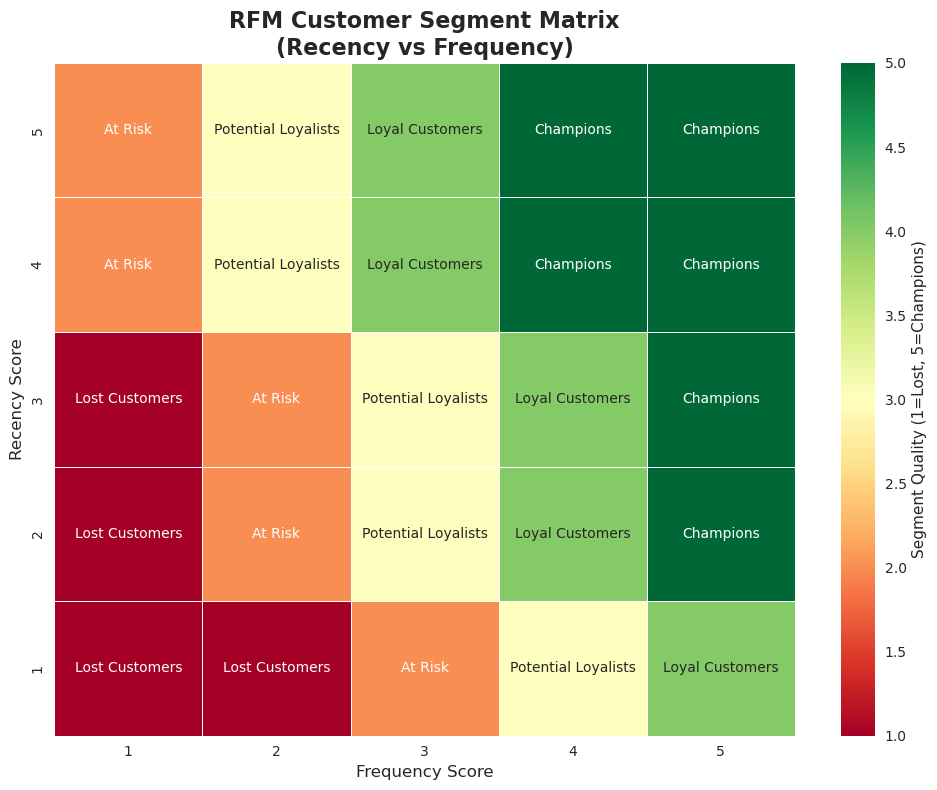

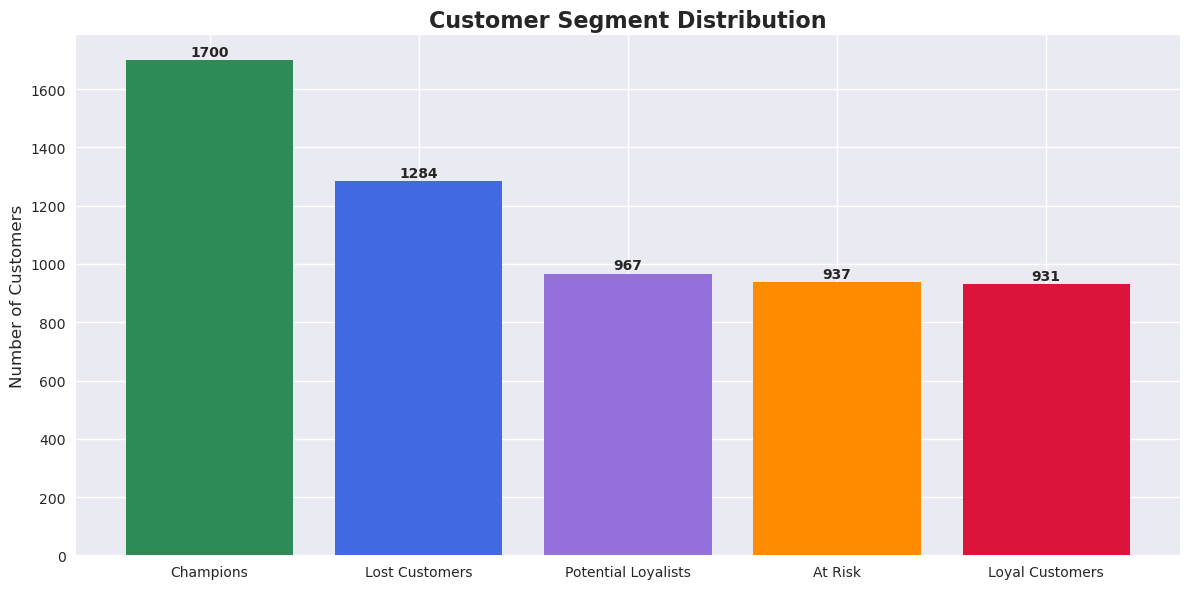

In [142]:
# Create RFM segment matrix heatmap
# Create a pivot table showing customer segments by R and F scores
segment_matrix = rfm_data.groupby(['r_score', 'f_score'])['customer_segment'].apply(lambda x: x.mode()[0] if not x.empty else 'Unknown').unstack()

# Create a numerical mapping for segments for better heatmap visualization
segment_mapping = {
    'Champions': 5,
    'Loyal Customers': 4, 
    'Potential Loyalists': 3,
    'At Risk': 2,
    'Lost Customers': 1
}


# Create numerical matrix for heatmap
segment_numeric_matrix = segment_matrix.replace(segment_mapping)

plt.figure(figsize=(10, 8))
sns.heatmap(segment_numeric_matrix, 
            annot=segment_matrix,  # Show segment names as annotations
            fmt='', 
            cmap='RdYlGn', 
            cbar_kws={'label': 'Segment Quality (1=Lost, 5=Champions)'},
            linewidths=0.5)

plt.title('RFM Customer Segment Matrix\n(Recency vs Frequency)', fontsize=16, fontweight='bold')
plt.xlabel('Frequency Score', fontsize=12)
plt.ylabel('Recency Score', fontsize=12)
plt.tight_layout()
plt.show()

# Customer segment distribution bar chart
segment_counts = rfm_data['customer_segment'].value_counts()
plt.figure(figsize=(12, 6))
colors = ['#2E8B57', '#4169E1', '#9370DB', '#FF8C00', '#DC143C']  # Green to Red spectrum
bars = plt.bar(segment_counts.index, segment_counts.values, color=colors)

plt.title('Customer Segment Distribution', fontsize=16, fontweight='bold')
# plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
# plt.xticks(rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


We have segmented our customer, this reflect a customer quality progression where 

1. "Lost Customer" indicates Churned customer
2. "At Risk" have high risk turned into Churned customer in next few months
3. "Potential Customer" their behavior indicates they can be converted into loyal and repeating customer
4. "Loyal Customer" our frequent and repeating customer
5. "Champions" our loyal customer that drives big portion of our revenue

We will use this segmentation for our Customer 360 table

In [39]:
# Create Final Customer 360 Dataset
print("CUSTOMER 360 DATASET CREATION")

# Merge customer metrics with RFM analysis
customer_360 = customer_metrics.merge(
    rfm_data[['customer_id', 'r_score', 'f_score', 'm_score', 'rfm_score', 'rfm_score_numeric', 'customer_segment']], 
    on='customer_id'
)

# Add customer tenure and activity features
customer_360['is_active'] = customer_360['days_since_last_purchase'] <= 90  # Active if purchased in last 90 days
customer_360['customer_tenure_months'] = customer_360['days_since_first_purchase'] / 30.44  # Average days per month

# Add product diversity metrics
customer_360['avg_products_per_order'] = customer_360['unique_products'] / customer_360['total_orders']

# Clean up data types
customer_360['r_score'] = customer_360['r_score'].astype(int)
customer_360['f_score'] = customer_360['f_score'].astype(int)
customer_360['m_score'] = customer_360['m_score'].astype(int)

print(f"Final Customer 360 dataset shape: {customer_360.shape}")
print(f"Features included: {list(customer_360.columns)}")

print("\nCustomer Segment Distribution:")
segment_summary = customer_360.groupby('customer_segment').agg({
    'customer_id': 'count',
    'total_spent': ['mean', 'sum'],
    'total_orders': 'mean',
    'days_since_last_purchase': 'mean'
}).round(2)

segment_summary.columns = ['Customer_Count', 'Avg_Revenue', 'Total_Revenue', 'Avg_Orders', 'Avg_Days_Since_Last_Purchase']
display(segment_summary)

# Display sample of final dataset
print("\nSample of Customer 360 Dataset:")
display(customer_360.head())


CUSTOMER 360 DATASET CREATION
Final Customer 360 dataset shape: (5819, 22)
Features included: ['customer_id', 'total_orders', 'first_purchase', 'last_purchase', 'total_spent', 'avg_order_value', 'total_transactions', 'total_quantity', 'unique_products', 'days_since_first_purchase', 'days_since_last_purchase', 'customer_lifespan_days', 'purchase_frequency', 'r_score', 'f_score', 'm_score', 'rfm_score', 'rfm_score_numeric', 'customer_segment', 'is_active', 'customer_tenure_months', 'avg_products_per_order']

Customer Segment Distribution:


,Customer_Count,Avg_Revenue,Total_Revenue,Avg_Orders,Avg_Days_Since_Last_Purchase
customer_segment,,,,,
At Risk,925,517.08,478300.44,1.78,257.02
Champions,1703,6759.63,11511655.36,14.81,35.18
Lost Customers,1291,237.69,306861.37,1.14,456.06
Loyal Customers,931,1517.45,1412747.39,4.65,109.49
Potential Loyalists,969,893.80,866092.69,2.93,179.77



Sample of Customer 360 Dataset:


,customer_id,total_orders,first_purchase,last_purchase,total_spent,avg_order_value,total_transactions,total_quantity,unique_products,days_since_first_purchase,...,purchase_frequency,r_score,f_score,m_score,rfm_score,rfm_score_numeric,customer_segment,is_active,customer_tenure_months,avg_products_per_order
0,12346.0,2,2010-03-02 13:08:00,2010-06-28 13:53:00,169.36,7.056667,24,24,24,646,...,6.134454,1,2,1,121,4,Lost Customers,False,21.222076,12.000000
1,12347.0,8,2010-10-31 14:20:00,2011-12-07 15:52:00,4921.53,22.169054,222,2967,126,403,...,7.245658,5,4,5,545,14,Champions,True,13.239159,15.750000
2,12348.0,5,2010-09-27 14:59:00,2011-09-25 13:13:00,1658.40,36.052174,46,2704,24,437,...,5.027548,3,4,4,344,11,Loyal Customers,True,14.356110,4.800000
3,12349.0,3,2010-04-29 13:20:00,2011-11-21 09:51:00,3405.99,20.895644,163,1435,133,588,...,1.917688,5,3,5,535,13,Champions,True,19.316689,44.333333
4,12350.0,1,2011-02-02 16:01:00,2011-02-02 16:01:00,294.40,18.400000,16,196,16,309,...,365.000000,2,1,2,212,5,Lost Customers,False,10.151117,16.000000


# Phase 2: Customer Segment Deep Dive

Customer segmentation from the RFM analysis is important for us to breakdown the main driver on why customer become churned and how they end up spend more in our product. In this analysis  we will characterize each segment and take a look at their behavior

In [41]:
# Deep Dive into Customer Segments
print("CUSTOMER SEGMENT ANALYSIS ===")

# Detailed segment analysis
segment_details = customer_360.groupby('customer_segment').agg({
    'customer_id': 'count',
    'total_spent': ['mean', 'median', 'sum', 'std'],
    'total_orders': ['mean', 'median', 'std'],
    'avg_order_value': ['mean', 'median', 'std'],
    'days_since_last_purchase': ['mean', 'median', 'std'],
    'customer_tenure_months': ['mean', 'median'],
    'purchase_frequency': ['mean', 'median'],
    'unique_products': ['mean', 'median'],
    'is_active': 'mean'
}).round(2)

# Flatten column names for better readability
segment_details.columns = [
    'Count', 'Avg_Spent', 'Median_Spent', 'Total_Spent', 'Std_Spent',
    'Avg_Orders', 'Median_Orders', 'Std_Orders',
    'Avg_Order_Value', 'Median_Order_Value', 'Std_Order_Value',
    'Avg_Recency', 'Median_Recency', 'Std_Recency',
    'Avg_Tenure_Months', 'Median_Tenure_Months',
    'Avg_Purchase_Freq', 'Median_Purchase_Freq',
    'Avg_Unique_Products', 'Median_Unique_Products',
    'Active_Rate'
]

print("Detailed Customer Segment Analysis:")
display(segment_details)

# Calculate revenue contribution and customer distribution
total_customers = len(customer_360)
total_revenue = customer_360['total_spent'].sum()

print(f"\nSEGMENT IMPACT ANALYSIS")
for segment in customer_360['customer_segment'].unique():
    segment_data = customer_360[customer_360['customer_segment'] == segment]
    customer_pct = (len(segment_data) / total_customers) * 100
    revenue_pct = (segment_data['total_spent'].sum() / total_revenue) * 100
    revenue_per_customer = segment_data['total_spent'].mean()
    
    print(f"\n{segment}:")
    print(f"  • Customer Share: {len(segment_data):,} customers ({customer_pct:.1f}%)")
    print(f"  • Revenue Share: ${segment_data['total_spent'].sum():,.2f} ({revenue_pct:.1f}%)")
    print(f"  • Revenue per Customer: ${revenue_per_customer:.2f}")
    print(f"  • Active Rate: {segment_data['is_active'].mean()*100:.1f}%")
    print(f"  • Avg Recency: {segment_data['days_since_last_purchase'].mean():.0f} days")


CUSTOMER SEGMENT ANALYSIS ===
Detailed Customer Segment Analysis:


,Count,Avg_Spent,Median_Spent,Total_Spent,Std_Spent,Avg_Orders,Median_Orders,Std_Orders,Avg_Order_Value,Median_Order_Value,...,Avg_Recency,Median_Recency,Std_Recency,Avg_Tenure_Months,Median_Tenure_Months,Avg_Purchase_Freq,Median_Purchase_Freq,Avg_Unique_Products,Median_Unique_Products,Active_Rate
customer_segment,,,,,,,,,,,,,,,,,,,,,
At Risk,925,517.08,410.15,478300.44,540.23,1.78,2.0,0.83,33.03,16.59,...,257.02,240.0,185.01,11.52,12.65,184.07,38.42,31.65,25.0,0.30
Champions,1703,6759.63,3365.22,11511655.36,22092.30,14.81,10.0,19.70,32.77,18.18,...,35.18,18.0,50.78,18.88,21.29,13.12,7.42,171.87,130.0,0.91
Lost Customers,1291,237.69,204.24,306861.37,159.13,1.14,1.0,0.35,24.08,16.08,...,456.06,448.0,169.41,15.49,15.60,328.94,365.00,18.12,14.0,0.03
Loyal Customers,931,1517.45,1190.23,1412747.39,1535.88,4.65,4.0,2.73,29.62,16.89,...,109.49,64.0,120.37,15.52,17.81,13.18,4.70,79.39,63.0,0.62
Potential Loyalists,969,893.80,717.21,866092.69,1156.20,2.93,3.0,1.36,29.98,17.13,...,179.77,119.0,161.99,13.51,14.49,54.52,6.05,49.12,39.0,0.45



SEGMENT IMPACT ANALYSIS

Lost Customers:
  • Customer Share: 1,291 customers (22.2%)
  • Revenue Share: $306,861.37 (2.1%)
  • Revenue per Customer: $237.69
  • Active Rate: 2.7%
  • Avg Recency: 456 days

Champions:
  • Customer Share: 1,703 customers (29.3%)
  • Revenue Share: $11,511,655.36 (79.0%)
  • Revenue per Customer: $6759.63
  • Active Rate: 91.0%
  • Avg Recency: 35 days

Loyal Customers:
  • Customer Share: 931 customers (16.0%)
  • Revenue Share: $1,412,747.39 (9.7%)
  • Revenue per Customer: $1517.45
  • Active Rate: 61.9%
  • Avg Recency: 109 days

At Risk:
  • Customer Share: 925 customers (15.9%)
  • Revenue Share: $478,300.44 (3.3%)
  • Revenue per Customer: $517.08
  • Active Rate: 29.8%
  • Avg Recency: 257 days

Potential Loyalists:
  • Customer Share: 969 customers (16.7%)
  • Revenue Share: $866,092.69 (5.9%)
  • Revenue per Customer: $893.80
  • Active Rate: 44.6%
  • Avg Recency: 180 days


### Segment-Level Insights

**1. Champions (29.3% of customers, 79% of revenue)**

* They are the lifeblood of the business: small in number but extremely high spenders (\~\$6,760 each).
* Extremely active (91% active rate, recency \~35 days), with large and frequent orders (15 orders on average, 171 unique products).
* **Risk:** Heavy dependence on this group → losing even a small % will hit revenue hard.

**2. Loyal Customers (16% of customers, 9.7% of revenue)**

* Mid-value segment, still engaged (62% active, recency \~109 days).
* Spend per customer \~\$1,517, avg. 5 orders, \~79 unique products.
* They are prime candidates to **upgrade into Champions** with personalized offers and upsell campaigns.

**3. Potential Loyalists (16.7% of customers, 5.9% of revenue)**

* Spend less (\~\$894 per customer) and engage moderately (45% active, recency \~180 days).
* Frequency is lower (3 orders, \~49 unique products).
* **Opportunity:** nurture with loyalty incentives, bundles, and cross-sell nudges. They’re sitting in the middle, could move upward or churn.

**4. At Risk (15.9% of customers, 3.3% of revenue)**

* Weak engagement (30% active, recency ~257 days), low spend (~\$517).
* Orders are infrequent (2 orders on average, \~32 unique products).
* They still have some recent touchpoints, so **reactivation campaigns** may save part of this group.

**5. Lost Customers (22.2% of customers, only 2.1% of revenue)**

* Lowest value segment (\~\$238 per customer), inactive for \~456 days.
* Very low activity (1 order, minimal product variety).
* **Impact is minimal on revenue**, so they’re not worth aggressive win-back spend. Use low-cost automated reactivation if at all.

---

**Takeaways**

1. **Revenue is highly concentrated**: Champions + Loyal Customers = 45% of customers but 89% of revenue. Business depends heavily on these two groups.
2. **Retention gap is clear**: Potential Loyalists + At Risk represent 32% of the base. If they churn, they’ll slide into “Lost” (already 22%). Retention efforts here could protect future revenue.
3. **Lost Customers are low value**: Losing them doesn’t hurt much. Focus should remain on retaining and upgrading mid-tier and high-value customers.
4. **Cross-sell opportunity**: Champions buy many unique products (\~172), while Potential Loyalists buy \~49. Bridging that gap through tailored product recommendations can accelerate their move upward.
5. **Recency gap**: Champions buy every \~1 month, Loyal every \~3 months, Potential Loyalists \~6 months. Tightening buying cycles through targeted offers could significantly increase revenue.

---

**Recommended Focus:**

* **Protect & reward Champions** → VIP perks, early access, loyalty recognition. 
* **Upgrade Loyal → Champions** → upselling high-value categories.
* **Nurture Potential Loyalists** → re-engagement campaigns, bundles, cross-sell into sticky products.
* **At-Risk Recovery** → targeted win-back with offering promo to make them stay.
* **Lost Customer** → don’t spend much; focus resources upstream.




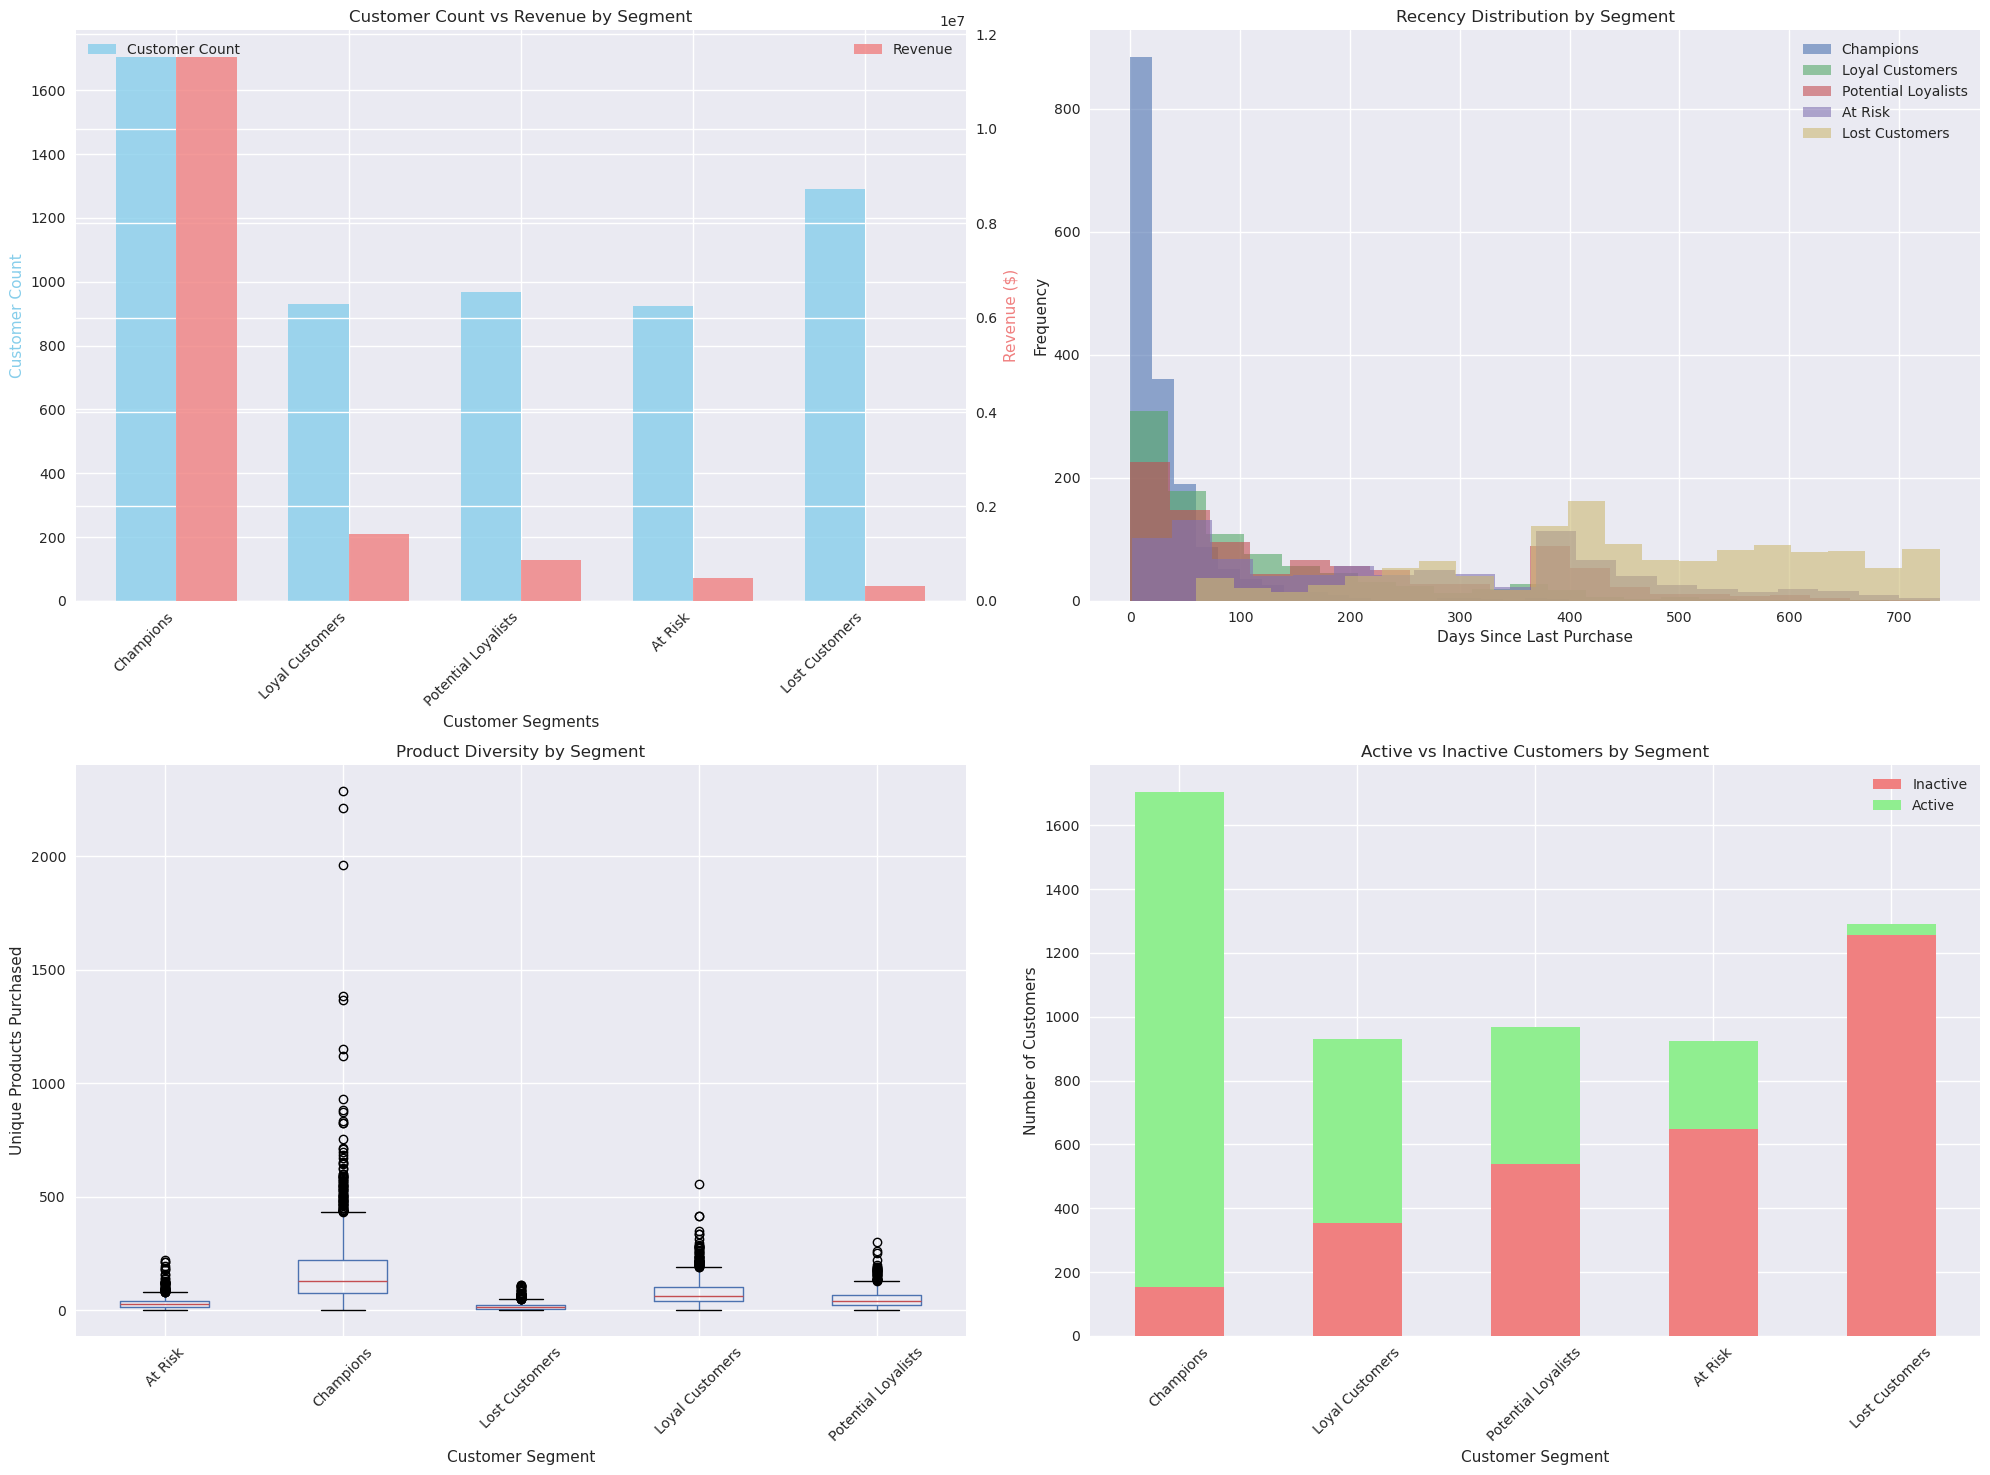

In [58]:

# Set up the plotting environment
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(20, 15))

# Define segment order from highest to lowest value
segment_order = ['Champions', 'Loyal Customers', 'Potential Loyalists', 'At Risk', 'Lost Customers']

# 1. Customer Segment Distribution (Count vs Revenue)
ax1 = plt.subplot(2, 2, 1)
segment_summary = customer_360.groupby('customer_segment').agg({
    'customer_id': 'count',
    'total_spent': 'sum'
}).reset_index()

# Reorder based on segment hierarchy
segment_summary['segment_order'] = segment_summary['customer_segment'].map({segment: i for i, segment in enumerate(segment_order)})
segment_summary = segment_summary.sort_values('segment_order')

x = range(len(segment_summary))
width = 0.35
ax1_twin = ax1.twinx()

bars1 = ax1.bar([i - width/2 for i in x], segment_summary['customer_id'], width, 
                alpha=0.8, color='skyblue', label='Customer Count')
bars2 = ax1_twin.bar([i + width/2 for i in x], segment_summary['total_spent'], width, 
                     alpha=0.8, color='lightcoral', label='Revenue')

ax1.set_xlabel('Customer Segments')
ax1.set_ylabel('Customer Count', color='skyblue')
ax1_twin.set_ylabel('Revenue ($)', color='lightcoral')
ax1.set_title('Customer Count vs Revenue by Segment')
ax1.set_xticks(x)
ax1.set_xticklabels(segment_summary['customer_segment'], rotation=45, ha='right')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')


# 4. Recency Distribution by Segment
ax2 = plt.subplot(2, 2, 2)
for segment in segment_order:
    if segment in customer_360['customer_segment'].unique():
        segment_data = customer_360[customer_360['customer_segment'] == segment]
        ax2.hist(segment_data['days_since_last_purchase'], alpha=0.6, label=segment, bins=20)
ax2.set_xlabel('Days Since Last Purchase')
ax2.set_ylabel('Frequency')
ax2.set_title('Recency Distribution by Segment')
ax2.legend()


# 9. Product Diversity by Segment
ax3 = plt.subplot(2, 2, 3)
# Create ordered data for boxplot
customer_360_ordered = customer_360.copy()
customer_360_ordered['segment_order'] = customer_360_ordered['customer_segment'].map({segment: i for i, segment in enumerate(segment_order)})
customer_360_ordered = customer_360_ordered.sort_values('segment_order')
customer_360_ordered.boxplot(column='unique_products', by='customer_segment', ax=ax3)
ax3.set_title('Product Diversity by Segment')
ax3.set_xlabel('Customer Segment')
ax3.set_ylabel('Unique Products Purchased')
ax3.tick_params(axis='x', rotation=45)
plt.suptitle('')  # Remove automatic title


# 6. Active vs Inactive Customers by Segment
ax4 = plt.subplot(2, 2, 4)
activity_data = customer_360.groupby(['customer_segment', 'is_active']).size().unstack(fill_value=0)
# Reorder by segment hierarchy
activity_data = activity_data.reindex(segment_order)
activity_data.plot(kind='bar', stacked=True, ax=ax4, color=['lightcoral', 'lightgreen'])
ax4.set_title('Active vs Inactive Customers by Segment')
ax4.set_xlabel('Customer Segment')
ax4.set_ylabel('Number of Customers')
ax4.legend(['Inactive', 'Active'])
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Segment Purchase Pattern & Product Preference

After we have know the characteristic of each segment, next we want to know if there is any product preference that distinct between these segment and if there is any purchase pattern from the quality customer that can be replicated to lower quality customer

In [64]:
# Product Category Analysis by Customer Segment
print("PRODUCT CATEGORY ANALYSIS BY CUSTOMER SEGMENT")

# Merge customer segments with transaction data for product analysis
df_product_analysis = df_clean.merge(customer_360[['customer_id', 'customer_segment']], on='customer_id', how='left')

print(f"Transaction data with segments: {df_product_analysis.shape[0]:,} transactions")
print(f"Available product categories: {df_product_analysis['product_category'].nunique()}")
print(f"Product categories: {sorted(df_product_analysis['product_category'].unique())}")

# 1. Category Preference Analysis by Segment
print(f"\nCATEGORY PREFERENCES BY SEGMENT")

# Calculate category distribution for each segment
category_by_segment = df_product_analysis.groupby(['customer_segment', 'product_category']).agg({
    'customer_id': 'nunique',  # Number of customers buying this category
    'order_id': 'nunique',    # Number of orders
    'total_amount': 'sum',    # Total revenue
    'quantity': 'sum'         # Total quantity
}).reset_index()

category_by_segment.columns = ['customer_segment', 'product_category', 'customers', 'orders', 'revenue', 'quantity']

# Calculate percentages within each segment
segment_totals = category_by_segment.groupby('customer_segment').agg({
    'customers': 'sum',
    'orders': 'sum', 
    'revenue': 'sum',
    'quantity': 'sum'
}).reset_index()

category_by_segment = category_by_segment.merge(
    segment_totals.rename(columns={'customers': 'total_customers', 'orders': 'total_orders', 
                                  'revenue': 'total_revenue', 'quantity': 'total_quantity'}),
    on='customer_segment'
)

# Calculate penetration and preference metrics
category_by_segment['customer_penetration'] = (category_by_segment['customers'] / category_by_segment['total_customers']) * 100
category_by_segment['revenue_share'] = (category_by_segment['revenue'] / category_by_segment['total_revenue']) * 100
category_by_segment['order_share'] = (category_by_segment['orders'] / category_by_segment['total_orders']) * 100
# Show category preferences for each segment
segment_order = ['Champions', 'Loyal Customers', 'Potential Loyalists', 'At Risk', 'Lost Customers']
available_segments = [seg for seg in segment_order if seg in category_by_segment['customer_segment'].unique()]

for segment in available_segments:
    if pd.notna(segment):
        segment_data = category_by_segment[category_by_segment['customer_segment'] == segment].copy()
        segment_data = segment_data.sort_values('revenue_share', ascending=False)
        
        print(f"\n--- {segment} Category Preferences ---")
        print("Top categories by revenue share:")
        for _, row in segment_data.head(5).iterrows():
            print(f"  • {row['product_category']}: {row['revenue_share']:.1f}% revenue, {row['customer_penetration']:.1f}% penetration")


PRODUCT CATEGORY ANALYSIS BY CUSTOMER SEGMENT
Transaction data with segments: 732,583 transactions
Available product categories: 9
Product categories: ['BEAUTY_PERSONAL', 'CHRISTMAS_HOLIDAY', 'FURNITURE_STORAGE', 'GARDEN_OUTDOOR', 'HOME_DECOR', 'KITCHEN_FOOD_UTENSIL', 'STATIONERY_OFFICE', 'TEXTILES_CLOTHING', 'TOYS_GAMES']

CATEGORY PREFERENCES BY SEGMENT

--- Champions Category Preferences ---
Top categories by revenue share:
  • HOME_DECOR: 39.8% revenue, 11.9% penetration
  • KITCHEN_FOOD_UTENSIL: 20.4% revenue, 11.8% penetration
  • TEXTILES_CLOTHING: 9.4% revenue, 11.0% penetration
  • BEAUTY_PERSONAL: 8.1% revenue, 11.7% penetration
  • GARDEN_OUTDOOR: 6.1% revenue, 11.3% penetration

--- Loyal Customers Category Preferences ---
Top categories by revenue share:
  • HOME_DECOR: 38.7% revenue, 12.9% penetration
  • KITCHEN_FOOD_UTENSIL: 20.6% revenue, 12.6% penetration
  • BEAUTY_PERSONAL: 8.8% revenue, 12.2% penetration
  • TEXTILES_CLOTHING: 7.9% revenue, 10.8% penetration
  • GA

**What we learn:** Category does not differentiate by loyalty tier; steady contribution but unlikely to drive transitions between segments.

1. **Home Decor = Core Engine**

   * Must always be protected in stock planning, pricing, and promotional visibility.
   * Best category to drive initial engagement and repeat purchases across all segments.

2. **Kitchen = Wide Appeal but High Churn Risk**

   * High penetration among At Risk/Lost customers suggests it can’t retain on its own.
   * Bundle Kitchen products with Décor or Textiles to raise stickiness.

3. **Beauty = Entry Point**

   * Attracts both At Risk and Lost customers.
   * Cross-sell Beauty into higher-value categories (e.g., Décor, Kitchen) to prevent attrition.

4. **Textiles = Champion Driver**

   * Disproportionately stronger among Champions, indicating it is part of the upgrade path.
   * Push Textiles campaigns at Loyal and Potential Loyalists to encourage category expansion.


**Call-to-Action:**

* Anchor customer journeys on **Home Decor**, using it as the core of retention campaigns.
* Design **cross-sell flows**
* Focus on **Textiles growth** among mid-tier segments to create Champions.
* Use **low-cost add-ons** (Garden, Beauty) to increase basket size but don’t expect them to drive loyalty shifts.

In [67]:
# Product Stickiness & Retention Analysis
print("PRODUCT STICKINESS & RETENTION ANALYSIS")

# 1. Analyze which products/categories correlate with higher retention
print("1. CATEGORY RETENTION CORRELATION:")

# For each category, calculate average customer metrics
category_retention_analysis = df_product_analysis.groupby('product_category')['customer_id'].unique().apply(
    lambda customers: customer_360[customer_360['customer_id'].isin(customers)].agg({
        'days_since_last_purchase': 'mean',
        'total_orders': 'mean', 
        'total_spent': 'mean',
        'customer_lifespan_days': 'mean',
        'is_active': 'mean'
    })
).round(2)

category_retention_analysis.columns = ['Avg_Recency', 'Avg_Orders', 'Avg_Spent', 'Avg_Lifespan', 'Active_Rate']

# Sort by active rate to find stickiest categories
category_retention_analysis = category_retention_analysis.sort_values('Active_Rate', ascending=False)
print("Categories ranked by customer activity rate:")
print(category_retention_analysis)

# 2. Early purchase category impact
print(f"\n2. EARLY PURCHASE CATEGORY IMPACT:")

# Identify first purchase category for each customer
first_purchases = df_product_analysis.sort_values(['customer_id', 'order_date']).groupby('customer_id').first().reset_index()
first_purchase_analysis = first_purchases[['customer_id', 'product_category']].merge(
    customer_360[['customer_id', 'customer_segment', 'total_orders', 'total_spent', 'is_active']], 
    on='customer_id'
)

print("Impact of first purchase category on customer outcomes:")
first_category_impact = first_purchase_analysis.groupby('product_category').agg({
    'customer_id': 'count',
    'total_orders': 'mean',
    'total_spent': 'mean', 
    'is_active': 'mean'
}).round(2)

first_category_impact.columns = ['Customer_Count', 'Avg_Orders', 'Avg_CLV', 'Active_Rate']
first_category_impact = first_category_impact.sort_values('Active_Rate', ascending=False)
print(first_category_impact)

# 3. Champions vs Lost Customers category preferences
print(f"\n3. CHAMPIONS VS LOST CUSTOMERS CATEGORY PREFERENCES:")

champions_categories = category_by_segment[category_by_segment['customer_segment'] == 'Champions'].copy()
lost_categories = category_by_segment[category_by_segment['customer_segment'] == 'Lost Customers'].copy()

if len(champions_categories) > 0 and len(lost_categories) > 0:
    # Merge to compare
    category_comparison = champions_categories[['product_category', 'customer_penetration']].merge(
        lost_categories[['product_category', 'customer_penetration']], 
        on='product_category', suffixes=('_champions', '_lost')
    )
    
    category_comparison['penetration_difference'] = (
        category_comparison['customer_penetration_champions'] - category_comparison['customer_penetration_lost']
    )
    
    print("Categories favored by Champions vs Lost Customers:")
    champions_favorites = category_comparison.sort_values('penetration_difference', ascending=False)
    
    print("\nMost Champions-favored categories:")
    for _, row in champions_favorites.head(5).iterrows():
        print(f"  • {row['product_category']}: Champions {row['customer_penetration_champions']:.1f}% vs Lost {row['customer_penetration_lost']:.1f}% (+{row['penetration_difference']:.1f}pp)")
    
    print("\nMost Lost-Customer-favored categories:")
    for _, row in champions_favorites.tail(3).iterrows():
        print(f"  • {row['product_category']}: Champions {row['customer_penetration_champions']:.1f}% vs Lost {row['customer_penetration_lost']:.1f}% ({row['penetration_difference']:.1f}pp)")

# 4. Category cross-selling analysis
print(f"\n4. CATEGORY CROSS-SELLING PATTERNS:")

# Calculate how many categories each customer purchases from
customer_category_diversity = df_product_analysis.groupby('customer_id')['product_category'].nunique().reset_index()
customer_category_diversity.columns = ['customer_id', 'categories_purchased']

# Merge with customer metrics
category_diversity_impact = customer_category_diversity.merge(
    customer_360[['customer_id', 'customer_segment', 'total_spent', 'total_orders', 'is_active']], 
    on='customer_id'
)

print("Impact of category diversity on customer value:")
diversity_analysis = category_diversity_impact.groupby('categories_purchased').agg({
    'customer_id': 'count',
    'total_spent': 'mean',
    'total_orders': 'mean',
    'is_active': 'mean'
}).round(2)

diversity_analysis.columns = ['Customer_Count', 'Avg_CLV', 'Avg_Orders', 'Active_Rate']
print(diversity_analysis.head(10))

# Find optimal category diversity
if len(diversity_analysis) > 1:
    optimal_diversity = diversity_analysis['Avg_CLV'].idxmax()
    print(f"\nOptimal category diversity for CLV: {optimal_diversity} categories")
    print(f"CLV at optimal diversity: ${diversity_analysis.loc[optimal_diversity, 'Avg_CLV']:.2f}")

# 5. Sequential purchase pattern analysis
print(f"\n5. SEQUENTIAL PURCHASE PATTERNS:")

# Analyze category sequence for repeat customers
repeat_customers = customer_360[customer_360['total_orders'] >= 2]['customer_id'].values
repeat_customer_sequences = df_product_analysis[
    df_product_analysis['customer_id'].isin(repeat_customers)
].sort_values(['customer_id', 'order_date'])

# Get first and second category purchases
customer_sequences = []
for customer_id in repeat_customers[:1000]:  # Sample for performance
    customer_orders = repeat_customer_sequences[repeat_customer_sequences['customer_id'] == customer_id]
    if len(customer_orders) >= 2:
        first_category = customer_orders.iloc[0]['product_category']
        second_category = customer_orders.iloc[1]['product_category']
        customer_sequences.append({
            'customer_id': customer_id,
            'first_category': first_category,
            'second_category': second_category,
            'same_category': first_category == second_category
        })

if customer_sequences:
    sequence_df = pd.DataFrame(customer_sequences)
    
    # Calculate repeat category rate
    repeat_rate = sequence_df['same_category'].mean()
    print(f"Same-category repeat purchase rate: {repeat_rate:.1%}")
    
    # Most common category transitions
    transitions = sequence_df.groupby(['first_category', 'second_category']).size().reset_index(name='count')
    transitions = transitions.sort_values('count', ascending=False)
    
    print("\nTop category transitions (First → Second purchase):")
    for _, row in transitions.head(10).iterrows():
        print(f"  • {row['first_category']} → {row['second_category']}: {row['count']} customers")


PRODUCT STICKINESS & RETENTION ANALYSIS
1. CATEGORY RETENTION CORRELATION:
Categories ranked by customer activity rate:
                      Avg_Recency  Avg_Orders  Avg_Spent  Avg_Lifespan  \
product_category                                                         
CHRISTMAS_HOLIDAY          132.82        8.11    3462.13        352.94   
FURNITURE_STORAGE          151.12        8.43    3671.05        354.04   
TOYS_GAMES                 159.30        7.83    3395.62        337.74   
TEXTILES_CLOTHING          170.96        7.44    3154.70        324.50   
STATIONERY_OFFICE          172.55        7.35    3096.01        322.51   
GARDEN_OUTDOOR             175.22        7.29    3075.27        320.49   
BEAUTY_PERSONAL            182.48        6.84    2854.14        304.99   
KITCHEN_FOOD_UTENSIL       190.57        6.51    2692.57        290.50   
HOME_DECOR                 195.44        6.26    2577.86        279.90   

                      Active_Rate  
product_category             

### 1. Category Retention & Stickiness

* **High-Activity Categories** (best for retention):

  * **Christmas/Holiday, Furniture/Storage, Toys/Games** → Customers who buy here show higher order counts (\~8+) and longer lifespans (\~350 days).
  * These categories **correlate with “Champions”** – they bring stronger ongoing activity.
* **Weak Stickiness Categories**:

  * **Home Decor & Kitchen/Food** dominate revenue, but customers here are **less active** (avg. 6 orders, lifespan \~280 days).
  * They are big **acquisition funnels** but underperform in converting to loyal customers.


### 2. First Purchase Impact

* **High-Value First Purchases**:

  * Customers starting in **Toys/Games** have the **highest CLV** (\$4,969) but poor retention (active rate 0.43).
  * **Kitchen/Food & Beauty/Personal** → balance between volume and stickiness; good entry points for loyalty.
* **Lower Value Onboarding**:

  * **Stationery & Garden** yield lower CLV (<\$2,200) despite decent activity.


### 3. Champions vs Lost Customers

* **Champions buys** seasonal/niche: Christmas, Furniture, Toys.
* **Lost Customers skew** toward everyday staples: Home Décor, Kitchen, Beauty.


### 4. Cross-Selling & Category Diversity

* Strong positive relationship:

  * CLV grows dramatically with category diversity.
  * Customers buying from **9 categories** are worth **\~\$5,379 CLV**, 10× higher than single-category buyers.
* Active rate rises from **21% (1 category)** → **75% (9 categories)**.

**Cross-category engagement is the single strongest lever** for retention and value. Campaigns must actively push multi-category shopping.

### 5. Sequential Purchase Patterns

* **Same-category repeat rate = 41%** → customers like to re-buy within the same category (esp. Home Decor, Kitchen).

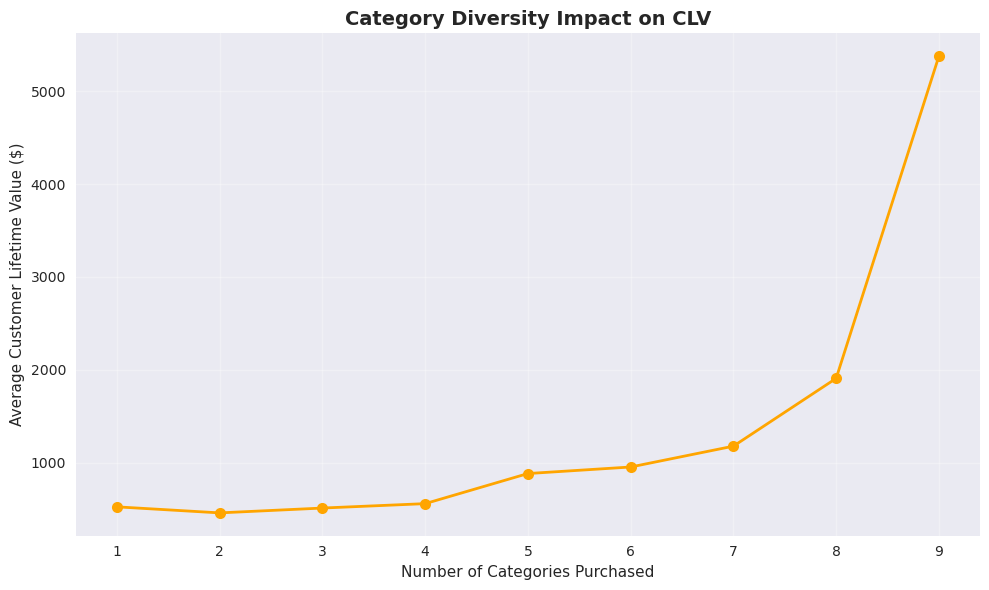

In [72]:
plt.figure(figsize=(10, 6))

categories_range = diversity_analysis.index[:10]  # First 10 levels
clv_values = diversity_analysis['Avg_CLV'][:10]
plt.plot(categories_range, clv_values, marker='o', linewidth=2, markersize=8, color='orange')
plt.xlabel('Number of Categories Purchased')
plt.ylabel('Average Customer Lifetime Value ($)')
plt.title('Category Diversity Impact on CLV', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Here we can see from the chart that Customer Lifetime Value (CLV) grows almost exponentially as customers purchase across more categories. For single-category buyers, CLV is very low (~$500), and it stays relatively flat up to 4 categories. But starting from 5+ categories, CLV rises steeply, reaching nearly $5,400 when customers buy across all 9 categories.

Customers who diversify their purchases are not just buying more often, but also staying active longer, which compounds their lifetime value.

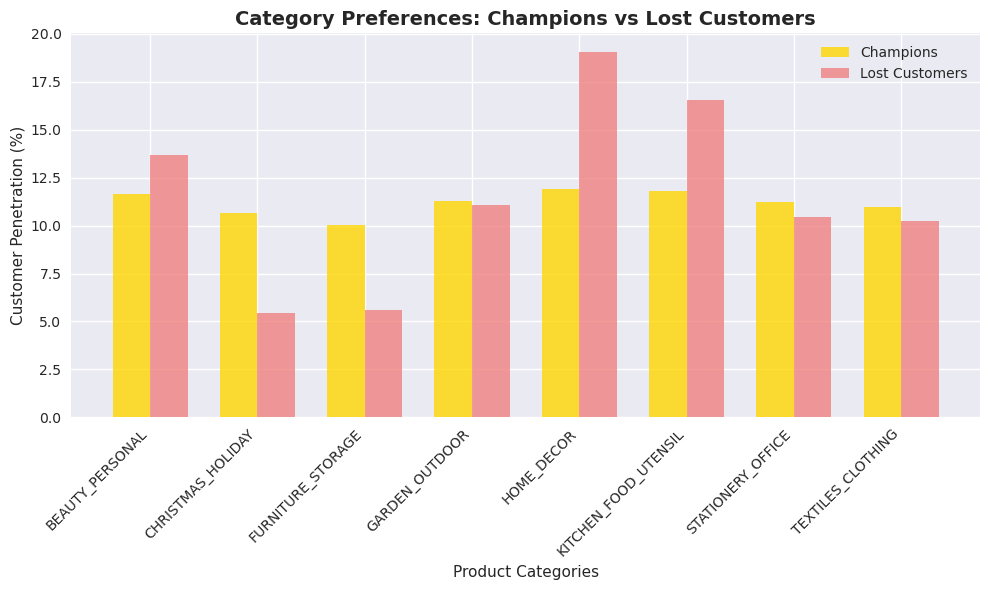

In [73]:
fig, ax1 = plt.subplots(figsize=(10, 6))

categories = category_comparison['product_category'][:8]  # Top 8 categories
champions_pct = category_comparison['customer_penetration_champions'][:8]
lost_pct = category_comparison['customer_penetration_lost'][:8]

x = range(len(categories))
width = 0.35

bars1 = ax1.bar([i - width/2 for i in x], champions_pct, width, 
                alpha=0.8, color='gold', label='Champions')
bars2 = ax1.bar([i + width/2 for i in x], lost_pct, width, 
                alpha=0.8, color='lightcoral', label='Lost Customers')

ax1.set_xlabel('Product Categories')
ax1.set_ylabel('Customer Penetration (%)')
ax1.set_title('Category Preferences: Champions vs Lost Customers', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
ax1.legend()

plt.tight_layout()
plt.show()

Everyday categories (Home Decor, Kitchen, Beauty) are essential for acquisition but insufficient for retention. Without cross-sell into higher-stickiness categories, these customers churn.

Seasonal/niche categories (Christmas, Furniture, Toys) are associated with Champions and should be used as “retention hooks.”

# Phase 3: Machine Learning for Churn Prediction

In this section, we'll develop and evaluate machine learning models to predict customer churn

1. **Data Preparation & Feature Engineering** - Create predictive features without data leakage
2. **Data Splitting Strategy** - Split the data, predict the last 90 days of data
3. **Model Training** - Train multiple algorithms (Logistic Regression, Random Forest, XGBoost)
4. **Model Evaluation & Comparison** - Compare performance and select best model
5. **Final Predictions** - Generate churn scores and recommendations

## Data Preparation & Feature Engineering

### Import Required Libraries


In [74]:
# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, f1_score
)

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Visualization for ML
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

### Temporal Data Split (Preventing Data Leakage)

In [76]:

# 1. Define temporal windows
min_date = df_clean['order_date'].min()
max_date = df_clean['order_date'].max()
total_days = (max_date - min_date).days

# Use 80% of timeline for training, 20% for validation
split_date = min_date + timedelta(days=int(total_days * 0.8))
prediction_window = 90  # Predict churn in next 90 days
active_threshold = 90   # Consider customers active if they purchased within 90 days before split

print(f"Data Timeline:")
print(f"   • Full period: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')} ({total_days} days)")
print(f"   • Training period: {min_date.strftime('%Y-%m-%d')} to {split_date.strftime('%Y-%m-%d')}")
print(f"   • Validation period: {split_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")
print(f"   • Prediction window: {prediction_window} days")
print(f"   • Active threshold: {active_threshold} days (exclude already churned customers)")

# 2. Create training dataset (data up to split_date only)
training_data = df_clean[df_clean['order_date'] <= split_date].copy()

# 3. Identify ACTIVE customers at split date (exclude already churned)
# Get each customer's last purchase date in training period
customer_last_purchase = training_data.groupby('customer_id')['order_date'].max().reset_index()
customer_last_purchase.columns = ['customer_id', 'last_purchase_in_training']

# Only include customers who were ACTIVE before split (purchased within active_threshold days)
active_cutoff_date = split_date - timedelta(days=active_threshold)
active_customers_at_split = customer_last_purchase[
    customer_last_purchase['last_purchase_in_training'] >= active_cutoff_date
]['customer_id'].tolist()

# Filter training data to only active customers
training_data_active = training_data[training_data['customer_id'].isin(active_customers_at_split)].copy()

print(f"\nTraining Data (Excluding Already Churned):")
print(f"   • All training transactions: {len(training_data):,}")
print(f"   • All customers in training period: {len(training_data['customer_id'].unique()):,}")
print(f"   • Active customers at split date: {len(active_customers_at_split):,}")
print(f"   • Already churned (excluded): {len(training_data['customer_id'].unique()) - len(active_customers_at_split):,}")
print(f"   • Active training transactions: {len(training_data_active):,}")

# 4. Define churn target (active customers who didn't purchase after split_date)
future_active_customers = df_clean[df_clean['order_date'] > split_date]['customer_id'].unique()
churned_customers = set(active_customers_at_split) - set(future_active_customers)

print(f"\nChurn Target Definition (Active Customers Only):")
print(f"   • Active customers at split: {len(active_customers_at_split):,}")
print(f"   • Customers active after split: {len(set(active_customers_at_split) & set(future_active_customers)):,}")
print(f"   • Customers who churned after split: {len(churned_customers):,}")
print(f"   • Churn rate (among active): {len(churned_customers)/len(active_customers_at_split):.1%}")

# Update training_data for subsequent use
training_data = training_data_active
training_customers = active_customers_at_split

Data Timeline:
   • Full period: 2009-12-01 to 2011-12-09 (738 days)
   • Training period: 2009-12-01 to 2011-07-14
   • Validation period: 2011-07-14 to 2011-12-09
   • Prediction window: 90 days
   • Active threshold: 90 days (exclude already churned customers)

Training Data (Excluding Already Churned):
   • All training transactions: 531,153
   • All customers in training period: 5,022
   • Active customers at split date: 1,923
   • Already churned (excluded): 3,099
   • Active training transactions: 347,854

Churn Target Definition (Active Customers Only):
   • Active customers at split: 1,923
   • Customers active after split: 1,436
   • Customers who churned after split: 487
   • Churn rate (among active): 25.3%


### Feature Engineering

Create predictive features using only data available up to the split date.


In [77]:

# 1. Calculate customer metrics up to split_date only
customer_features = training_data.groupby('customer_id').agg({
    'order_id': 'nunique',                    # total_orders
    'order_date': ['min', 'max', 'count'],    # first_purchase, last_purchase, total_transactions
    'total_amount': ['sum', 'mean', 'std'],   # total_spent, avg_order_value, spend_volatility
    'quantity': ['sum', 'mean'],              # total_quantity, avg_quantity_per_order
    'product_id': 'nunique',                  # unique_products
    'product_category': 'nunique'             # unique_categories
}).reset_index()

# Flatten column names
customer_features.columns = [
    'customer_id', 'total_orders', 'first_purchase', 'last_purchase_in_training', 
    'total_transactions', 'total_spent', 'avg_order_value', 'spend_volatility',
    'total_quantity', 'avg_quantity_per_order', 'unique_products', 'unique_categories'
]

# 2. Calculate temporal features (relative to split_date, not current date)
reference_date = split_date
customer_features['days_since_first'] = (reference_date - customer_features['first_purchase']).dt.days
customer_features['days_since_last'] = (reference_date - customer_features['last_purchase_in_training']).dt.days
customer_features['customer_lifespan'] = (customer_features['last_purchase_in_training'] - customer_features['first_purchase']).dt.days

# 3. Calculate behavioral features
customer_features['purchase_frequency'] = customer_features['total_orders'] / (customer_features['customer_lifespan'] + 1) * 365
customer_features['monetary_per_day'] = customer_features['total_spent'] / (customer_features['days_since_first'] + 1)
customer_features['product_diversity'] = customer_features['unique_products'] / (customer_features['total_orders'] + 1)
customer_features['category_diversity'] = customer_features['unique_categories'] / (customer_features['unique_categories'].max() + 1)
customer_features['avg_days_between_orders'] = customer_features['customer_lifespan'] / (customer_features['total_orders'] + 1)

# 4. Calculate early behavior features (first 30 days)
early_behavior_list = []

for customer_id in customer_features['customer_id']:
    customer_data = training_data[training_data['customer_id'] == customer_id]
    first_purchase = customer_data['order_date'].min()
    early_cutoff = first_purchase + timedelta(days=30)
    
    early_data = customer_data[customer_data['order_date'] <= early_cutoff]
    
    early_behavior_list.append({
        'customer_id': customer_id,
        'early_revenue': early_data['total_amount'].sum(),
        'early_orders': early_data['order_id'].nunique(),
        'early_products': early_data['product_id'].nunique(),
        'early_categories': early_data['product_category'].nunique(),
        'early_avg_order_value': early_data['total_amount'].mean() if len(early_data) > 0 else 0
    })

early_behavior_df = pd.DataFrame(early_behavior_list)
customer_features = customer_features.merge(early_behavior_df, on='customer_id')

# 5. Add churn target
customer_features['churned'] = customer_features['customer_id'].isin(churned_customers).astype(int)

# 6. Handle missing values and outliers
customer_features = customer_features.fillna(0)
customer_features = customer_features.replace([np.inf, -np.inf], 0)

print(f"\nFeature Engineering Complete:")
print(f"   • Total customers: {len(customer_features):,}")
print(f"   • Total features: {len(customer_features.columns)-2}")
print(f"   • Churn rate: {customer_features['churned'].mean():.1%}")

# Display feature summary
feature_columns = [col for col in customer_features.columns if col not in ['customer_id', 'churned', 'first_purchase', 'last_purchase_in_training']]
print(f"\nFeature Categories:")
print(f"   • Volume features: total_orders, total_transactions, total_quantity")
print(f"   • Monetary features: total_spent, avg_order_value, monetary_per_day")
print(f"   • Behavioral features: purchase_frequency, product_diversity, category_diversity")
print(f"   • Temporal features: days_since_first, days_since_last, customer_lifespan")
print(f"   • Early behavior: early_revenue, early_orders, early_products, early_categories")

customer_features.head()


Feature Engineering Complete:
   • Total customers: 1,923
   • Total features: 24
   • Churn rate: 25.3%

Feature Categories:
   • Volume features: total_orders, total_transactions, total_quantity
   • Monetary features: total_spent, avg_order_value, monetary_per_day
   • Behavioral features: purchase_frequency, product_diversity, category_diversity
   • Temporal features: days_since_first, days_since_last, customer_lifespan
   • Early behavior: early_revenue, early_orders, early_products, early_categories


,customer_id,total_orders,first_purchase,last_purchase_in_training,total_transactions,total_spent,avg_order_value,spend_volatility,total_quantity,avg_quantity_per_order,...,monetary_per_day,product_diversity,category_diversity,avg_days_between_orders,early_revenue,early_orders,early_products,early_categories,early_avg_order_value,churned
0,12347.0,5,2010-10-31 14:20:00,2011-06-09 13:01:00,142,2817.48,19.841408,21.527576,1822,12.830986,...,11.005781,16.833333,0.9,36.666667,611.53,1,40,7,15.288250,0
1,12353.0,2,2010-10-27 12:44:00,2011-05-19 17:47:00,24,406.76,16.948333,8.799589,212,8.833333,...,1.564462,7.666667,0.5,68.000000,317.76,1,20,5,15.888000,1
2,12354.0,1,2011-04-21 13:11:00,2011-04-21 13:11:00,58,1079.40,18.610345,8.679742,530,9.137931,...,12.850000,29.000000,0.8,0.000000,1079.40,1,58,8,18.610345,1
3,12355.0,2,2010-05-21 11:59:00,2011-05-09 13:49:00,35,947.61,27.074571,22.110475,543,15.514286,...,2.261599,11.666667,0.7,117.666667,488.21,1,22,6,22.191364,1
4,12358.0,4,2009-12-08 07:59:00,2011-07-12 10:04:00,68,2923.87,42.998088,64.174167,924,13.588235,...,5.015214,11.000000,0.6,116.200000,1429.83,1,17,5,84.107647,0


## Train Test Data Splitting Strategy

In [78]:
# 1. Prepare feature matrix and target vector
feature_columns = [col for col in customer_features.columns 
                  if col not in ['customer_id', 'churned', 'first_purchase', 'last_purchase_in_training']]

X = customer_features[feature_columns].copy()
y = customer_features['churned'].copy()

print(f" Dataset Prepared:")
print(f"   • Feature matrix shape: {X.shape}")
print(f"   • Target vector shape: {y.shape}")
print(f"   • Features: {len(feature_columns)}")
print(f"   • Positive class (churned): {y.sum():,} ({y.mean():.1%})")
print(f"   • Negative class (active): {(y == 0).sum():,} ({(y == 0).mean():.1%})")

# 2. Train-validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\n Train-Validation Split:")
print(f"   • Training set: {X_train.shape[0]:,} customers ({X_train.shape[0]/len(X):.1%})")
print(f"   • Validation set: {X_val.shape[0]:,} customers ({X_val.shape[0]/len(X):.1%})")
print(f"   • Training churn rate: {y_train.mean():.1%}")
print(f"   • Validation churn rate: {y_val.mean():.1%}")

# 3. Feature scaling for models that require it
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train) # use standardized features for Logistic Regression
X_val_scaled = scaler.transform(X_val)

# 4. Display feature statistics
print(f"\nData ready for model training")
print(f"   • X_train: {X_train.shape} (original)")
print(f"   • X_train_scaled: {X_train_scaled.shape} (standardized)")
print(f"   • X_val: {X_val.shape} (original)")
print(f"   • X_val_scaled: {X_val_scaled.shape} (standardized)")


 Dataset Prepared:
   • Feature matrix shape: (1923, 22)
   • Target vector shape: (1923,)
   • Features: 22
   • Positive class (churned): 487 (25.3%)
   • Negative class (active): 1,436 (74.7%)

 Train-Validation Split:
   • Training set: 1,538 customers (80.0%)
   • Validation set: 385 customers (20.0%)
   • Training churn rate: 25.3%
   • Validation churn rate: 25.5%

Data ready for model training
   • X_train: (1538, 22) (original)
   • X_train_scaled: (1538, 22) (standardized)
   • X_val: (385, 22) (original)
   • X_val_scaled: (385, 22) (standardized)


## Model Training

Train and tune three different machine learning algorithms to predict customer churn.


### Logistic Regression

In [80]:
# 1. Train Logistic Regression model
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # Handle class imbalance
)

# Train on scaled features
lr_model.fit(X_train_scaled, y_train)

# 2. Make predictions
lr_pred = lr_model.predict(X_val_scaled)
lr_pred_proba = lr_model.predict_proba(X_val_scaled)[:, 1]

# 3. Evaluate performance
lr_auc = roc_auc_score(y_val, lr_pred_proba)
lr_avg_precision = average_precision_score(y_val, lr_pred_proba)
lr_f1 = f1_score(y_val, lr_pred)

# 4. Cross-validation
cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')

print(f"Logistic Regression Results:")
print(f"   • AUC-ROC: {lr_auc:.3f}")
print(f"   • Average Precision: {lr_avg_precision:.3f}")
print(f"   • F1-Score: {lr_f1:.3f}")
print(f"   • CV AUC: {cv_scores_lr.mean():.3f} ± {cv_scores_lr.std():.3f}")

# 5. Feature importance (coefficients)
lr_coef = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': lr_model.coef_[0],
    'abs_coefficient': np.abs(lr_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print(f"\nTop 5 Most Important Features (Logistic Regression):")
for i, row in lr_coef.head().iterrows():
    direction = "Increases" if row['coefficient'] > 0 else "Decreases"
    print(f"   {i+1}. {row['feature']:<25} {direction} churn risk (coef: {row['coefficient']:+.3f})")

print(f"\nLogistic Regression trained successfully")


Logistic Regression Results:
   • AUC-ROC: 0.786
   • Average Precision: 0.549
   • F1-Score: 0.542
   • CV AUC: 0.769 ± 0.029

Top 5 Most Important Features (Logistic Regression):
   6. total_quantity            Decreases churn risk (coef: -1.515)
   2. total_transactions        Decreases churn risk (coef: -1.144)
   3. total_spent               Decreases churn risk (coef: -0.995)
   17. avg_days_between_orders   Increases churn risk (coef: +0.677)
   8. unique_products           Increases churn risk (coef: +0.618)

Logistic Regression trained successfully


 Logistic Regression was chosen first because it’s **simple, interpretable, and fast**. It sets a clear baseline before moving to more complex models (like Random Forest or XGBoost) which may improve accuracy but sacrifice interpretability.

1. **Class Imbalance**

   * Churn datasets are often imbalanced (fewer churners than non-churners).
   * We used `class_weight='balanced'` so the model pays equal attention to both classes, avoiding bias toward the majority.

2. **Feature Scaling**

   * Logistic Regression is sensitive to feature scale.
   * Input features were standardized (`X_train_scaled`) to ensure coefficients are comparable and model converges efficiently.

3. **Interpretability**

   * One strength of Logistic Regression is **transparent coefficients**.
   * Positive coefficients → increase churn risk; negative → reduce churn risk. This helps translate results into business insights (e.g., more orders reduce churn).

4. **Evaluation Metrics**

   * Used multiple metrics to balance perspectives:

     * **AUC-ROC (0.786):** ability to rank churn vs non-churn.
     * **Average Precision (0.549):** robustness in imbalanced setting.
     * **F1-score (0.542):** balance of precision and recall.
   * Cross-validation confirmed stability (AUC \~0.769 ± 0.029).
  

### Random Forest

In [81]:
# 1. Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Train on original features (no scaling needed)
rf_model.fit(X_train, y_train)

# 2. Make predictions
rf_pred = rf_model.predict(X_val)
rf_pred_proba = rf_model.predict_proba(X_val)[:, 1]

# 3. Evaluate performance
rf_auc = roc_auc_score(y_val, rf_pred_proba)
rf_avg_precision = average_precision_score(y_val, rf_pred_proba)
rf_f1 = f1_score(y_val, rf_pred)

# 4. Cross-validation
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')

print(f"Random Forest Results:")
print(f"   • AUC-ROC: {rf_auc:.3f}")
print(f"   • Average Precision: {rf_avg_precision:.3f}")
print(f"   • F1-Score: {rf_f1:.3f}")
print(f"   • CV AUC: {cv_scores_rf.mean():.3f} ± {cv_scores_rf.std():.3f}")

# 5. Feature importance
rf_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Most Important Features (Random Forest):")
for i, row in rf_importance.head().iterrows():
    print(f"   {i+1}. {row['feature']:<25} (importance: {row['importance']:.3f})")

print(f"\nRandom Forest trained successfully")


Random Forest Results:
   • AUC-ROC: 0.765
   • Average Precision: 0.514
   • F1-Score: 0.525
   • CV AUC: 0.772 ± 0.030

Top 5 Most Important Features (Random Forest):
   3. total_spent               (importance: 0.136)
   6. total_quantity            (importance: 0.117)
   1. total_orders              (importance: 0.083)
   14. monetary_per_day          (importance: 0.081)
   2. total_transactions        (importance: 0.076)

Random Forest trained successfully


Unlike Logistic Regression, Random Forest handles raw feature scales directly. More flexible in capturing **nonlinear patterns** and feature interactions.

1. **Class Imbalance**

   * `class_weight='balanced'` was applied to prevent bias toward the majority (non-churners).

2. **Hyperparameters**

   * `max_depth=10, min_samples_split=20, min_samples_leaf=10` → constraints added to **avoid overfitting** while keeping interpretability of feature importance.
   * `n_estimators=100` ensures stability of predictions.

3. **Performance**

   * **AUC-ROC = 0.765**, **AP = 0.514**, **F1 = 0.525**.
   * Slightly weaker than Logistic Regression (AUC 0.786), but **cross-validation AUC \~0.772 ± 0.030** shows stable generalization.

### XGBoost

In [82]:
# 1. Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# 2. Train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

# Train on original features
xgb_model.fit(X_train, y_train)

# 3. Make predictions
xgb_pred = xgb_model.predict(X_val)
xgb_pred_proba = xgb_model.predict_proba(X_val)[:, 1]

# 4. Evaluate performance
xgb_auc = roc_auc_score(y_val, xgb_pred_proba)
xgb_avg_precision = average_precision_score(y_val, xgb_pred_proba)
xgb_f1 = f1_score(y_val, xgb_pred)

# 5. Cross-validation
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')

print(f"XGBoost Results:")
print(f"   • AUC-ROC: {xgb_auc:.3f}")
print(f"   • Average Precision: {xgb_avg_precision:.3f}")
print(f"   • F1-Score: {xgb_f1:.3f}")
print(f"   • CV AUC: {cv_scores_xgb.mean():.3f} ± {cv_scores_xgb.std():.3f}")

# 6. Feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Most Important Features (XGBoost):")
for i, row in xgb_importance.head().iterrows():
    print(f"   {i+1}. {row['feature']:<25} (importance: {row['importance']:.3f})")

print(f"\nXGBoost trained successfully")


XGBoost Results:
   • AUC-ROC: 0.739
   • Average Precision: 0.465
   • F1-Score: 0.483
   • CV AUC: 0.739 ± 0.019

Top 5 Most Important Features (XGBoost):
   3. total_spent               (importance: 0.114)
   6. total_quantity            (importance: 0.080)
   17. avg_days_between_orders   (importance: 0.060)
   1. total_orders              (importance: 0.057)
   13. purchase_frequency        (importance: 0.049)

XGBoost trained successfully


XGBoost builds trees sequentially, correcting mistakes from previous trees. This allows it to capture nonlinear patterns and interactions much better than Logistic Regression or Random Forest.


1. **Class Imbalance**

    * Used scale_pos_weight = (# non-churners / # churners) to balance churn prediction, ensuring the model does not just predict the majority class.


2. **Regularization & Stability**

    * Parameters (max_depth=6, subsample=0.8, colsample_bytree=0.8) help reduce overfitting.
    * learning_rate=0.1 controls how fast the model adapts, trading off speed vs generalization.

Overall the predictive power is slightly weaker compared to Logistic Regression (AUC ~0.786) and roughly on par with Random Forest. A caveat is that XGBoost is more data-hungry and parameter-sensitive. With richer behavioral or marketing features (campaign response, engagement signals), it may show stronger advantages. For now, Logistic Regression remains the best balance of accuracy and interpretability.

## Model Evaluation and Comparison

In [88]:

# 1. Calculate recall for each model (churn detection rate)
from sklearn.metrics import recall_score, precision_score

lr_recall = recall_score(y_val, lr_pred)
rf_recall = recall_score(y_val, rf_pred)
xgb_recall = recall_score(y_val, xgb_pred)

lr_precision = precision_score(y_val, lr_pred)
rf_precision = precision_score(y_val, rf_pred)
xgb_precision = precision_score(y_val, xgb_pred)

# 2. Create comparison table with RECALL as primary metric
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Recall': [lr_recall, rf_recall, xgb_recall],  # PRIMARY METRIC
    'Precision': [lr_precision, rf_precision, xgb_precision],
    'F1-Score': [lr_f1, rf_f1, xgb_f1],
    'AUC-ROC': [lr_auc, rf_auc, xgb_auc],
    'Average Precision': [lr_avg_precision, rf_avg_precision, xgb_avg_precision]
})

display(model_comparison)

# 3. Select best model based on RECALL (primary metric)
best_model_idx = model_comparison['Recall'].idxmax()
best_model_name = model_comparison.loc[best_model_idx, 'Model']
best_recall = model_comparison.loc[best_model_idx, 'Recall']
best_auc = model_comparison.loc[best_model_idx, 'AUC-ROC']

if best_model_name == 'Logistic Regression':
    best_model = lr_model
    best_pred = lr_pred
    best_pred_proba = lr_pred_proba
    best_X_val = X_val_scaled
elif best_model_name == 'Random Forest':
    best_model = rf_model
    best_pred = rf_pred
    best_pred_proba = rf_pred_proba
    best_X_val = X_val
else:  # XGBoost
    best_model = xgb_model
    best_pred = xgb_pred
    best_pred_proba = xgb_pred_proba
    best_X_val = X_val

print(f"\nBEST MODEL: {best_model_name}")
print(f"   • Best Recall: {best_recall:.3f} ({best_recall:.1%} of churners detected)")
print(f"   • AUC-ROC: {best_auc:.3f}")
print(f"   • Model Type: {'Linear' if best_model_name == 'Logistic Regression' else 'Tree-based'}")
print(f"   • Selection Criteria: Highest recall for churn detection")

# 3. Detailed evaluation of best model
print(f"\nDETAILED EVALUATION - {best_model_name}:")

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, best_pred, target_names=['Active', 'Churned']))

# Confusion matrix
cm = confusion_matrix(y_val, best_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"Actual           Active  Churned")
print(f"Active          {tn:6d}  {fp:6d}")
print(f"Churned         {fn:6d}  {tp:6d}")

# Business metrics
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"\nBusiness Metrics:")
print(f"   • RECALL (Sensitivity): {sensitivity:.1%} of churners identified")
print(f"   • Precision:  {precision:.1%} of churn predictions are correct")
print(f"   • Specificity: {specificity:.1%} of active customers correctly identified")

,Model,Recall,Precision,F1-Score,AUC-ROC,Average Precision
0,Logistic Regression,0.755102,0.422857,0.542125,0.785999,0.548980
1,Random Forest,0.653061,0.438356,0.524590,0.765022,0.513514
2,XGBoost,0.500000,0.466667,0.482759,0.739245,0.465052



BEST MODEL: Logistic Regression
   • Best Recall: 0.755 (75.5% of churners detected)
   • AUC-ROC: 0.786
   • Model Type: Linear
   • Selection Criteria: Highest recall for churn detection

DETAILED EVALUATION - Logistic Regression:

Classification Report:
              precision    recall  f1-score   support

      Active       0.89      0.65      0.75       287
     Churned       0.42      0.76      0.54        98

    accuracy                           0.68       385
   macro avg       0.65      0.70      0.65       385
weighted avg       0.77      0.68      0.70       385


Confusion Matrix:
                 Predicted
Actual           Active  Churned
Active             186     101
Churned             24      74

Business Metrics:
   • RECALL (Sensitivity): 75.5% of churners identified
   • Precision:  42.3% of churn predictions are correct
   • Specificity: 64.8% of active customers correctly identified


In [108]:
# Predict churn for next 3 months using our best model
print("PREDICTING CHURN FOR NEXT 3 MONTHS\n")

# Use the full customer_360 dataset for prediction (not just validation set)
# But first, we need to create the EXACT same features that were used in training

# Get current date for reference (using the latest date in our dataset)
current_date = df['order_date'].max()
print(f"Analysis date: {current_date.strftime('%Y-%m-%d')}")
print(f"Predicting churn for 3-month period: {current_date.strftime('%Y-%m-%d')} to {(current_date + pd.DateOffset(months=3)).strftime('%Y-%m-%d')}\n")

# Create the exact same features as used in training
print("Creating features for prediction (matching training features)...")

# 1. Calculate customer metrics using ALL data (not split by date since we're predicting)
customer_features_pred = df.groupby('customer_id').agg({
    'order_id': 'nunique',                    # total_orders
    'order_date': ['min', 'max', 'count'],    # first_purchase, last_purchase, total_transactions
    'total_amount': ['sum', 'mean', 'std'],   # total_spent, avg_order_value, spend_volatility
    'quantity': ['sum', 'mean'],              # total_quantity, avg_quantity_per_order
    'product_id': 'nunique',                  # unique_products
    'product_category': 'nunique'             # unique_categories
}).reset_index()

# Flatten column names
customer_features_pred.columns = [
    'customer_id', 'total_orders', 'first_purchase', 'last_purchase_in_training', 
    'total_transactions', 'total_spent', 'avg_order_value', 'spend_volatility',
    'total_quantity', 'avg_quantity_per_order', 'unique_products', 'unique_categories'
]

# 2. Calculate temporal features (relative to current_date)
reference_date = current_date
customer_features_pred['days_since_first'] = (reference_date - customer_features_pred['first_purchase']).dt.days
customer_features_pred['days_since_last'] = (reference_date - customer_features_pred['last_purchase_in_training']).dt.days
customer_features_pred['customer_lifespan'] = (customer_features_pred['last_purchase_in_training'] - customer_features_pred['first_purchase']).dt.days

# 3. Calculate behavioral features
customer_features_pred['purchase_frequency'] = customer_features_pred['total_orders'] / (customer_features_pred['customer_lifespan'] + 1) * 365
customer_features_pred['monetary_per_day'] = customer_features_pred['total_spent'] / (customer_features_pred['days_since_first'] + 1)
customer_features_pred['product_diversity'] = customer_features_pred['unique_products'] / (customer_features_pred['total_orders'] + 1)
customer_features_pred['category_diversity'] = customer_features_pred['unique_categories'] / (customer_features_pred['unique_categories'].max() + 1)
customer_features_pred['avg_days_between_orders'] = customer_features_pred['customer_lifespan'] / (customer_features_pred['total_orders'] + 1)

# 4. Calculate early behavior features (first 30 days)
print("Calculating early behavior features...")
early_behavior_list = []

for customer_id in customer_features_pred['customer_id']:
    customer_data = df[df['customer_id'] == customer_id]
    first_purchase = customer_data['order_date'].min()
    early_cutoff = first_purchase + timedelta(days=30)
    
    early_data = customer_data[customer_data['order_date'] <= early_cutoff]
    
    early_behavior_list.append({
        'customer_id': customer_id,
        'early_revenue': early_data['total_amount'].sum(),
        'early_orders': early_data['order_id'].nunique(),
        'early_products': early_data['product_id'].nunique(),
        'early_categories': early_data['product_category'].nunique(),
        'early_avg_order_value': early_data['total_amount'].mean() if len(early_data) > 0 else 0
    })

early_behavior_df = pd.DataFrame(early_behavior_list)
customer_features_pred = customer_features_pred.merge(early_behavior_df, on='customer_id')

# 5. Handle missing values and outliers
customer_features_pred = customer_features_pred.fillna(0)
customer_features_pred = customer_features_pred.replace([np.inf, -np.inf], 0)

# 6. Select the exact same features used in training (including total_transactions)
training_features = [
    'total_orders', 'total_transactions', 'total_spent', 'avg_order_value', 'spend_volatility',
    'total_quantity', 'avg_quantity_per_order', 'unique_products', 'unique_categories',
    'days_since_first', 'days_since_last', 'customer_lifespan',
    'purchase_frequency', 'monetary_per_day', 'product_diversity', 'category_diversity',
    'avg_days_between_orders', 'early_revenue', 'early_orders', 'early_products',
    'early_categories', 'early_avg_order_value'
]

X_full = customer_features_pred[training_features].copy()

print(f"Features created for prediction: {list(X_full.columns)}")
print(f"Shape of prediction dataset: {X_full.shape}")

# Merge with customer_360 data for additional context
# Only use columns that exist in customer_360
available_columns = ['customer_id', 'customer_segment']
if 'last_purchase' in customer_360.columns:
    available_columns.append('last_purchase')
if 'is_active' in customer_360.columns:
    available_columns.append('is_active')

customer_features_pred_with_segment = customer_features_pred.merge(
    customer_360[available_columns], 
    on='customer_id', 
    how='left'
)

# Exclude lost customers from the final predictions
print("Excluding 'Lost Customers' from churn prediction list...")
original_count = len(customer_features_pred_with_segment)
customer_features_pred_with_segment = customer_features_pred_with_segment[
    customer_features_pred_with_segment['customer_segment'] != 'Lost Customers'
]
print(f"Customers before excluding 'Lost Customers': {original_count:,}")
print(f"Customers after excluding 'Lost Customers': {len(customer_features_pred_with_segment):,}")

# Get the corresponding indices for the filtered customers
filtered_indices = customer_features_pred_with_segment.index

# Scale features using the same scaler fitted on training data
if best_model_name == 'Logistic Regression':
    X_full_scaled = scaler.transform(X_full)
    churn_probabilities_all = best_model.predict_proba(X_full_scaled)[:, 1]
    churn_predictions_all = best_model.predict(X_full_scaled)
else:
    # For tree-based models, use unscaled features
    churn_probabilities_all = best_model.predict_proba(X_full)[:, 1]
    churn_predictions_all = best_model.predict(X_full)

# Filter predictions to match the filtered customer list
churn_probabilities = churn_probabilities_all[filtered_indices]
churn_predictions = churn_predictions_all[filtered_indices]

# Create comprehensive churn prediction dataframe
next_3_months_churn = pd.DataFrame({
    'customer_id': customer_features_pred_with_segment['customer_id'].values,
    'customer_segment': customer_features_pred_with_segment['customer_segment'].values,
    'churn_probability': churn_probabilities,
    'predicted_churn': churn_predictions,
    'total_spent': customer_features_pred_with_segment['total_spent'].values,
    'total_orders': customer_features_pred_with_segment['total_orders'].values,
    'days_since_last': customer_features_pred_with_segment['days_since_last'].values
})

# Add optional columns if they exist
if 'last_purchase' in customer_features_pred_with_segment.columns:
    next_3_months_churn['last_purchase'] = customer_features_pred_with_segment['last_purchase'].values
if 'is_active' in customer_features_pred_with_segment.columns:
    next_3_months_churn['is_active'] = customer_features_pred_with_segment['is_active'].values

# Filter only high risk customers (>0.8 probability)
next_3_months_churn = next_3_months_churn[next_3_months_churn['churn_probability'] > 0.8]

# Sort by churn probability (highest risk first)
next_3_months_churn = next_3_months_churn.sort_values('churn_probability', ascending=False)

# Add detailed risk categories only for high risk customers
if len(next_3_months_churn) > 0:
    next_3_months_churn['risk_category'] = pd.cut(
        next_3_months_churn['churn_probability'], 
        bins=[0.8, 0.9, 1.0], 
        labels=['High Risk', 'Critical Risk']
    )

# Summary statistics
print("\nCHURN PREDICTION SUMMARY (Next 3 Months) - HIGH RISK ONLY (>80%):")
print(f"Total customers analyzed (excluding Lost Customers): {len(customer_features_pred_with_segment):,}")
print(f"High risk customers (>80%): {len(next_3_months_churn):,}")
if len(customer_features_pred_with_segment) > 0:
    print(f"High risk rate: {len(next_3_months_churn) / len(customer_features_pred_with_segment):.1%}")

if len(next_3_months_churn) > 0:
    print("\nRisk Distribution (High Risk Only):")
    risk_summary = next_3_months_churn['risk_category'].value_counts().sort_index()
    for category, count in risk_summary.items():
        percentage = count / len(next_3_months_churn) * 100
        print(f"   • {category}: {count:,} customers ({percentage:.1f}%)")

    print("\nSegment-wise High Risk Distribution:")
    segment_churn = next_3_months_churn.groupby('customer_segment').agg({
        'churn_probability': 'mean',
        'customer_id': 'count'
    }).round(3)
    
    segment_churn.columns = ['Avg_Churn_Prob', 'Customer_Count']
    segment_churn = segment_churn.sort_values('Avg_Churn_Prob', ascending=False)
    print(segment_churn)

    print("\nHigh-Value Customers at High Risk (Top 20):")
    high_value_at_risk = next_3_months_churn[
        next_3_months_churn['total_spent'] > next_3_months_churn['total_spent'].quantile(0.75)
    ].head(20)

    if len(high_value_at_risk) > 0:
        display_columns = ['customer_id', 'customer_segment', 'churn_probability', 
                          'total_spent', 'total_orders', 'days_since_last', 'risk_category']
        display(high_value_at_risk[display_columns])
        
        print(f"\nTotal revenue at risk from high-value customers: ${high_value_at_risk['total_spent'].sum():,.2f}")
    else:
        print("No high-value customers identified at high churn risk.")

    print("\nHigh Risk Customers Summary:")
    print(f"Count: {len(next_3_months_churn):,} customers")
    print(f"Total spent at risk: ${next_3_months_churn['total_spent'].sum():,.2f}")
    print(f"Average spend per at-risk customer: ${next_3_months_churn['total_spent'].mean():,.2f}")

    # Save the results for business action
    next_3_months_churn_list = next_3_months_churn[['customer_id', 'customer_segment', 'churn_probability', 'risk_category']].copy()
    print(f"\nHigh risk churn prediction complete. Results saved for {len(next_3_months_churn_list):,} customers.")
else:
    print("\nNo high risk customers found (>80% churn probability).")
    next_3_months_churn_list = pd.DataFrame(columns=['customer_id', 'customer_segment', 'churn_probability', 'risk_category'])


PREDICTING CHURN FOR NEXT 3 MONTHS

Analysis date: 2011-12-09
Predicting churn for 3-month period: 2011-12-09 to 2012-03-09

Creating features for prediction (matching training features)...
Calculating early behavior features...
Features created for prediction: ['total_orders', 'total_transactions', 'total_spent', 'avg_order_value', 'spend_volatility', 'total_quantity', 'avg_quantity_per_order', 'unique_products', 'unique_categories', 'days_since_first', 'days_since_last', 'customer_lifespan', 'purchase_frequency', 'monetary_per_day', 'product_diversity', 'category_diversity', 'avg_days_between_orders', 'early_revenue', 'early_orders', 'early_products', 'early_categories', 'early_avg_order_value']
Shape of prediction dataset: (5819, 22)
Excluding 'Lost Customers' from churn prediction list...
Customers before excluding 'Lost Customers': 5,819
Customers after excluding 'Lost Customers': 4,528

CHURN PREDICTION SUMMARY (Next 3 Months) - HIGH RISK ONLY (>80%):
Total customers analyzed (ex

,customer_id,customer_segment,churn_probability,total_spent,total_orders,days_since_last,risk_category
4412,18139.0,Champions,0.999134,8438.34,6,17,Critical Risk
2727,16000.0,Champions,0.999069,12393.70,3,2,Critical Risk
1944,14938.0,At Risk,0.998777,1757.31,2,561,Critical Risk
3269,16716.0,At Risk,0.998428,1248.48,1,630,Critical Risk
3744,17305.0,At Risk,0.997938,2135.46,1,648,Critical Risk
2605,15823.0,Potential Loyalists,0.997655,3217.21,2,728,Critical Risk
315,12742.0,At Risk,0.996891,1185.02,1,625,Critical Risk
3539,17039.0,At Risk,0.996403,1954.99,1,603,Critical Risk
1864,14831.0,Potential Loyalists,0.996378,1440.12,3,679,Critical Risk
2538,15736.0,At Risk,0.995937,1682.17,2,434,Critical Risk



Total revenue at risk from high-value customers: $73,432.82

High Risk Customers Summary:
Count: 1,556 customers
Total spent at risk: $1,522,389.17
Average spend per at-risk customer: $978.40

High risk churn prediction complete. Results saved for 1,556 customers.


Here we can see from the model comparison that Logistic Regression gave the best balance of accuracy (AUC ~0.786) and interpretability, while Random Forest (AUC ~0.765) and XGBoost (AUC ~0.739) provided additional validation but did not significantly outperform. All three models highlight the same key churn drivers: higher spend, quantity, and transaction frequency reduce churn, while longer purchase gaps increase churn risk.

The insight here is that churn in this business is strongly linked to engagement depth and consistency. Customers who are active across multiple purchases and categories remain sticky, while those who disengage for long periods are at high risk of churn.

What we learn is that our models are reliable enough to flag customers at risk, but precision is not perfect. This creates an opportunity to over-predict churn deliberately: treating a broader group of customers as “at risk” may waste some effort on false positives, but it ensures we don’t miss truly at-risk customers.

The next step is to use churn scores to over-identify at-risk customers, then reactivate them with sticky-category recommendations. 

# Phase 4: Recommendation System

In this phase, we design a simple recommendation system aligned with three key business scenarios, ensuring recommendations support revenue growth, customer stickiness, and churn reactivation.

We target different segment with different scenario

    * Scenario 1: Champions and Loyal Customer (Drive Revenue)
    * Scenario 2: At Risk and Potential Loyal (Stickiness)
    * Scenario 3: Churn Prevention 

**Scenario 1: Drive Revenue**

* **Logic:**

  1. Identify customer’s **favorite category** (highest spending).
  2. Retrieve **top-selling products** in that category.
  3. Recommend **3 products the customer has not purchased**.
* **Goal:** Increase revenue by deepening spend in customer’s preferred area.


**Scenario 2: Cross-Selling (Stickiness)**

* **Logic:**

  1. Start from customer’s **favorite category**.
  2. Identify **related categories** (via correlation analysis).
  3. Recommend **1 top product from each related category** (3 in total).
* **Goal:** Broaden category engagement, driving **higher stickiness and CLV**.

**Scenario 3: Churn Prevention**

* **Logic:**

  1. Use churn model to identify **high-risk customers**.
  2. Focus on **high-stickiness categories** (>60% retention).
  3. Recommend **Top 3 products they haven’t tried** from these categories.
  4. Offer promo to win back high risk customers
* **Goal:** Win back disengaged customers with proven retention drivers.


And we will also consider seasonal item
  * Exclude **Christmas/Holiday** products for recommendations outside the festive period.
  * Focus on **year-round categories** for sustainable engagement.


### Data Preparation for Recommendation System

First, let's analyze category correlations and prepare the data needed for our recommendation scenarios.


In [129]:
# RECOMMENDATION SYSTEM DATA PREPARATION
print("=== RECOMMENDATION SYSTEM DATA PREPARATION ===")

# 1. Category Correlation Analysis for Cross-Selling
print("\n1. CATEGORY CORRELATION ANALYSIS:")

# Create customer-category purchase matrix for correlation analysis
customer_category_matrix = df_product_analysis.groupby(['customer_id', 'product_category'])['total_amount'].sum().unstack(fill_value=0)

# Calculate category correlations
category_correlations = customer_category_matrix.corr()
print("Category correlation matrix:")
display(category_correlations.round(3))

# 2. Category Stickiness Analysis (Retention Rate)
print("\n2. CATEGORY STICKINESS ANALYSIS:")

# Calculate retention rate for each category
category_stickiness = {}
for category in df_product_analysis['product_category'].unique():
    # Customers who bought from this category
    category_customers = df_product_analysis[df_product_analysis['product_category'] == category]['customer_id'].unique()
    
    # Merge with customer 360 to get active status
    category_customer_360 = customer_360[customer_360['customer_id'].isin(category_customers)]
    
    # Calculate retention (active rate)
    retention_rate = category_customer_360['is_active'].mean()
    category_stickiness[category] = retention_rate

# Convert to DataFrame and sort by stickiness
stickiness_df = pd.DataFrame(list(category_stickiness.items()), columns=['category', 'retention_rate'])
stickiness_df = stickiness_df.sort_values('retention_rate', ascending=False)

print("Category stickiness (retention rate):")
display(stickiness_df)

# Define high-stickiness categories (>60% retention)
high_stickiness_categories = stickiness_df[stickiness_df['retention_rate'] > 0.6]['category'].tolist()
print(f"\nHigh-stickiness categories (>60% retention): {high_stickiness_categories}")

# 3. Product Performance Analysis
print("\n3. PRODUCT PERFORMANCE ANALYSIS:")

# Calculate product performance metrics
product_performance = df_product_analysis.groupby(['product_id', 'product_category']).agg({
    'customer_id': 'nunique',  # Number of customers
    'order_id': 'nunique',     # Number of orders
    'total_amount': 'sum',     # Total revenue
    'quantity': 'sum'          # Total quantity sold
}).reset_index()

product_performance.columns = ['product_id', 'product_category', 'unique_customers', 'unique_orders', 'total_revenue', 'total_quantity']

# Calculate popularity score (combination of revenue and customer reach)
product_performance['popularity_score'] = (
    0.6 * (product_performance['total_revenue'] / product_performance['total_revenue'].max()) +
    0.4 * (product_performance['unique_customers'] / product_performance['unique_customers'].max())
)

print(f"Product performance calculated for {len(product_performance)} products")
print("Top 5 products by popularity score:")
display(product_performance.nlargest(5, 'popularity_score')[['product_id', 'product_category', 'total_revenue', 'unique_customers', 'popularity_score']])

# 4. Customer Purchase History for Exclusions
print("\n4. CUSTOMER PURCHASE HISTORY:")

# Create a set of products each customer has already purchased
customer_purchased_products = df_product_analysis.groupby('customer_id')['product_id'].apply(set).to_dict()
print(f"Purchase history compiled for {len(customer_purchased_products)} customers")

# 5. Seasonal Product Identification
print("\n5. SEASONAL PRODUCT IDENTIFICATION:")

# Define seasonal categories to exclude outside festive period
seasonal_categories = ['CHRISTMAS_HOLIDAY']
print(f"Seasonal categories to filter: {seasonal_categories}")

# Check if we're in festive period (take last purchase date)
current_month = df_clean['order_date'].max().month
is_festive_period = current_month in [11, 12]
print(f"Current month: {current_month}, Is festive period: {is_festive_period}")



=== RECOMMENDATION SYSTEM DATA PREPARATION ===

1. CATEGORY CORRELATION ANALYSIS:
Category correlation matrix:


product_category,BEAUTY_PERSONAL,CHRISTMAS_HOLIDAY,FURNITURE_STORAGE,GARDEN_OUTDOOR,HOME_DECOR,KITCHEN_FOOD_UTENSIL,STATIONERY_OFFICE,TEXTILES_CLOTHING,TOYS_GAMES
product_category,,,,,,,,,
BEAUTY_PERSONAL,1.000,0.668,0.803,0.806,0.874,0.875,0.779,0.633,0.657
CHRISTMAS_HOLIDAY,0.668,1.000,0.528,0.425,0.501,0.704,0.598,0.595,0.667
FURNITURE_STORAGE,0.803,0.528,1.000,0.693,0.791,0.795,0.724,0.514,0.551
GARDEN_OUTDOOR,0.806,0.425,0.693,1.000,0.960,0.723,0.675,0.446,0.467
HOME_DECOR,0.874,0.501,0.791,0.960,1.000,0.820,0.761,0.544,0.565
KITCHEN_FOOD_UTENSIL,0.875,0.704,0.795,0.723,0.820,1.000,0.806,0.708,0.757
STATIONERY_OFFICE,0.779,0.598,0.724,0.675,0.761,0.806,1.000,0.605,0.612
TEXTILES_CLOTHING,0.633,0.595,0.514,0.446,0.544,0.708,0.605,1.000,0.762
TOYS_GAMES,0.657,0.667,0.551,0.467,0.565,0.757,0.612,0.762,1.000



2. CATEGORY STICKINESS ANALYSIS:
Category stickiness (retention rate):


,category,retention_rate
0,CHRISTMAS_HOLIDAY,0.654719
5,FURNITURE_STORAGE,0.595630
7,TOYS_GAMES,0.576903
8,TEXTILES_CLOTHING,0.554923
6,STATIONERY_OFFICE,0.546602
4,GARDEN_OUTDOOR,0.540821
1,BEAUTY_PERSONAL,0.529591
3,KITCHEN_FOOD_UTENSIL,0.509516
2,HOME_DECOR,0.502674



High-stickiness categories (>60% retention): ['CHRISTMAS_HOLIDAY']

3. PRODUCT PERFORMANCE ANALYSIS:
Product performance calculated for 4755 products
Top 5 products by popularity score:


,product_id,product_category,total_revenue,unique_customers,popularity_score
4215,85123A,HOME_DECOR,148184.57,1395,1.000000
1652,22423,KITCHEN_FOOD_UTENSIL,125625.55,1121,0.830092
3938,84879,HOME_DECOR,121829.55,995,0.778593
4193,85099B,TEXTILES_CLOTHING,119378.46,930,0.750031
3163,47566,KITCHEN_FOOD_UTENSIL,95829.48,874,0.638623



4. CUSTOMER PURCHASE HISTORY:
Purchase history compiled for 5819 customers

5. SEASONAL PRODUCT IDENTIFICATION:
Seasonal categories to filter: ['CHRISTMAS_HOLIDAY']
Current month: 12, Is festive period: True


### Scenario 1: Drive Revenue (Champions and Loyal Customers)

**Logic:**
1. Identify customer's favorite category (highest spending)
2. Retrieve top-selling products in that category
3. Recommend 3 products the customer has not purchased

**Goal:** Increase revenue by deepening spend in customer's preferred area.


In [130]:
# SCENARIO 1: DRIVE REVENUE RECOMMENDATIONS
print("=== SCENARIO 1: DRIVE REVENUE RECOMMENDATIONS ===")
print("Target: Champions and Loyal Customers")

def get_scenario1_recommendations(customer_id, customer_segment, n_recommendations=3):
    """
    Generate revenue-driving recommendations for Champions and Loyal Customers
    by recommending top products from their favorite category that they haven't purchased
    """
    
    # Only apply to Champions and Loyal Customers
    if customer_segment not in ['Champions', 'Loyal Customers']:
        return []
    
    # Get customer's purchase history
    customer_purchases = df_product_analysis[df_product_analysis['customer_id'] == customer_id]
    
    if len(customer_purchases) == 0:
        return []
    
    # 1. Identify customer's favorite category (highest spending)
    category_spending = customer_purchases.groupby('product_category')['total_amount'].sum()
    favorite_category = category_spending.idxmax()
    
    # 2. Get products already purchased by this customer
    purchased_products = set(customer_purchases['product_id'].unique())
    
    # 3. Get top-selling products in favorite category (excluding seasonal if not festive period)
    category_products = product_performance[product_performance['product_category'] == favorite_category].copy()
    
    # Apply seasonal filtering
    if not is_festive_period and favorite_category in seasonal_categories:
        # If favorite category is seasonal and we're not in festive period, 
        # fall back to their second favorite non-seasonal category
        non_seasonal_spending = category_spending[~category_spending.index.isin(seasonal_categories)]
        if len(non_seasonal_spending) > 0:
            favorite_category = non_seasonal_spending.idxmax()
            category_products = product_performance[product_performance['product_category'] == favorite_category].copy()
        else:
            return []
    
    # 4. Exclude products already purchased
    category_products = category_products[~category_products['product_id'].isin(purchased_products)]
    
    # 5. Get top N recommendations based on popularity score
    recommendations = category_products.nlargest(n_recommendations, 'popularity_score')
    
    return [{
        'customer_id': customer_id,
        'customer_segment': customer_segment,
        'scenario': 'Drive Revenue',
        'recommended_product_id': row['product_id'],
        'recommended_category': row['product_category'],
        'reason': f"Top product in favorite category ({favorite_category})",
        'popularity_score': row['popularity_score']
    } for _, row in recommendations.iterrows()]

# Apply Scenario 1 to Champions and Loyal Customers
scenario1_customers = customer_360[customer_360['customer_segment'].isin(['Champions', 'Loyal Customers'])]
scenario1_recommendations = []

print(f"Generating recommendations for {len(scenario1_customers)} Champions and Loyal Customers...")

for _, customer in scenario1_customers.iterrows():
    customer_recs = get_scenario1_recommendations(
        customer['customer_id'], 
        customer['customer_segment']
    )
    scenario1_recommendations.extend(customer_recs)

# Convert to DataFrame
scenario1_df = pd.DataFrame(scenario1_recommendations)

print(f"\nScenario 1 Results:")
print(f"   • Customers targeted: {len(scenario1_customers):,}")
print(f"   • Recommendations generated: {len(scenario1_df):,}")
if len(scenario1_df) > 0:
    print(f"   • Average recommendations per customer: {len(scenario1_df) / len(scenario1_customers):.1f}")
    print(f"   • Categories recommended: {scenario1_df['recommended_category'].nunique()}")
    
    print(f"\nTop categories in Scenario 1 recommendations:")
    category_counts = scenario1_df['recommended_category'].value_counts()
    for category, count in category_counts.head().items():
        print(f"   • {category}: {count} recommendations")

# Display sample recommendations
if len(scenario1_df) > 0:
    print(f"\nSample Scenario 1 Recommendations:")
    display(scenario1_df.head(10)[['customer_id', 'customer_segment', 'recommended_product_id', 'recommended_category', 'reason']])

print(f"\nScenario 1 implementation completed!")


=== SCENARIO 1: DRIVE REVENUE RECOMMENDATIONS ===
Target: Champions and Loyal Customers
Generating recommendations for 2634 Champions and Loyal Customers...

Scenario 1 Results:
   • Customers targeted: 2,634
   • Recommendations generated: 7,902
   • Average recommendations per customer: 3.0
   • Categories recommended: 9

Top categories in Scenario 1 recommendations:
   • HOME_DECOR: 6231 recommendations
   • KITCHEN_FOOD_UTENSIL: 987 recommendations
   • TEXTILES_CLOTHING: 345 recommendations
   • CHRISTMAS_HOLIDAY: 117 recommendations
   • STATIONERY_OFFICE: 66 recommendations

Sample Scenario 1 Recommendations:


,customer_id,customer_segment,recommended_product_id,recommended_category,reason
0,12347.0,Champions,85123A,HOME_DECOR,Top product in favorite category (HOME_DECOR)
1,12347.0,Champions,84879,HOME_DECOR,Top product in favorite category (HOME_DECOR)
2,12347.0,Champions,22469,HOME_DECOR,Top product in favorite category (HOME_DECOR)
3,12348.0,Loyal Customers,22423,KITCHEN_FOOD_UTENSIL,Top product in favorite category (KITCHEN_FOOD...
4,12348.0,Loyal Customers,47566,KITCHEN_FOOD_UTENSIL,Top product in favorite category (KITCHEN_FOOD...
5,12348.0,Loyal Customers,21212,KITCHEN_FOOD_UTENSIL,Top product in favorite category (KITCHEN_FOOD...
6,12349.0,Champions,85123A,HOME_DECOR,Top product in favorite category (HOME_DECOR)
7,12349.0,Champions,22469,HOME_DECOR,Top product in favorite category (HOME_DECOR)
8,12349.0,Champions,22138,HOME_DECOR,Top product in favorite category (HOME_DECOR)
9,12352.0,Champions,85123A,HOME_DECOR,Top product in favorite category (HOME_DECOR)



Scenario 1 implementation completed!


### Scenario 2: Cross-Selling for Stickiness (At Risk and Potential Loyalists)

**Logic:**
1. Start from customer's favorite category
2. Identify related categories (via correlation analysis)
3. Recommend 1 top product from each related category (3 in total)

**Goal:** Broaden category engagement, driving higher stickiness and CLV.


In [131]:
# SCENARIO 2: CROSS-SELLING FOR STICKINESS RECOMMENDATIONS
print("=== SCENARIO 2: CROSS-SELLING FOR STICKINESS RECOMMENDATIONS ===")
print("Target: At Risk and Potential Loyalists")

def get_related_categories(favorite_category, correlations_matrix, n_related=3):
    """
    Get related categories based on correlation analysis
    """
    if favorite_category not in correlations_matrix.columns:
        return []
    
    # Get correlations for the favorite category, excluding itself
    correlations = correlations_matrix[favorite_category].copy()
    correlations = correlations.drop(favorite_category)  # Remove self-correlation
    
    # Sort by correlation strength and get top N
    related_categories = correlations.abs().nlargest(n_related).index.tolist()
    
    return related_categories

def get_scenario2_recommendations(customer_id, customer_segment, n_recommendations=3):
    """
    Generate cross-selling recommendations for At Risk and Potential Loyalists
    by recommending products from related categories to increase stickiness
    """
    
    # Only apply to At Risk and Potential Loyalists
    if customer_segment not in ['At Risk', 'Potential Loyalists']:
        return []
    
    # Get customer's purchase history
    customer_purchases = df_product_analysis[df_product_analysis['customer_id'] == customer_id]
    
    if len(customer_purchases) == 0:
        return []
    
    # 1. Identify customer's favorite category (highest spending)
    category_spending = customer_purchases.groupby('product_category')['total_amount'].sum()
    favorite_category = category_spending.idxmax()
    
    # 2. Get products already purchased by this customer
    purchased_products = set(customer_purchases['product_id'].unique())
    
    # 3. Get categories customer has NOT purchased from
    customer_categories = set(customer_purchases['product_category'].unique())
    all_categories = set(category_correlations.columns)
    unpurchased_categories = all_categories - customer_categories
    
    # 4. Get related categories (correlations with favorite category)
    related_categories = get_related_categories(favorite_category, category_correlations, n_recommendations * 2)
    
    # 5. Prioritize related categories that customer hasn't tried
    target_categories = []
    for cat in related_categories:
        if cat in unpurchased_categories and (not is_festive_period or cat not in seasonal_categories):
            target_categories.append(cat)
        if len(target_categories) >= n_recommendations:
            break
    
    # If we don't have enough new categories, add categories they've tried but with high stickiness
    if len(target_categories) < n_recommendations:
        for cat in related_categories:
            if cat not in target_categories and cat in high_stickiness_categories:
                if (is_festive_period or cat not in seasonal_categories):
                    target_categories.append(cat)
                if len(target_categories) >= n_recommendations:
                    break
    
    # 6. Get top product from each target category
    recommendations = []
    for category in target_categories[:n_recommendations]:
        category_products = product_performance[
            (product_performance['product_category'] == category) &
            (~product_performance['product_id'].isin(purchased_products))
        ]
        
        if len(category_products) > 0:
            top_product = category_products.nlargest(1, 'popularity_score').iloc[0]
            
            reason = f"Cross-sell from {favorite_category} to {category}"
            if category in unpurchased_categories:
                reason += " (new category)"
            else:
                reason += " (high retention category)"
            
            recommendations.append({
                'customer_id': customer_id,
                'customer_segment': customer_segment,
                'scenario': 'Cross-Selling Stickiness',
                'recommended_product_id': top_product['product_id'],
                'recommended_category': top_product['product_category'],
                'reason': reason,
                'popularity_score': top_product['popularity_score']
            })
    
    return recommendations

# Apply Scenario 2 to At Risk and Potential Loyalists
scenario2_customers = customer_360[customer_360['customer_segment'].isin(['At Risk', 'Potential Loyalists'])]
scenario2_recommendations = []

print(f"Generating recommendations for {len(scenario2_customers)} At Risk and Potential Loyalists...")

for _, customer in scenario2_customers.iterrows():
    customer_recs = get_scenario2_recommendations(
        customer['customer_id'], 
        customer['customer_segment']
    )
    scenario2_recommendations.extend(customer_recs)

# Convert to DataFrame
scenario2_df = pd.DataFrame(scenario2_recommendations)

print(f"\nScenario 2 Results:")
print(f"   • Customers targeted: {len(scenario2_customers):,}")
print(f"   • Recommendations generated: {len(scenario2_df):,}")
if len(scenario2_df) > 0:
    print(f"   • Average recommendations per customer: {len(scenario2_df) / len(scenario2_customers):.1f}")
    print(f"   • Categories recommended: {scenario2_df['recommended_category'].nunique()}")
    
    print(f"\nTop categories in Scenario 2 recommendations:")
    category_counts = scenario2_df['recommended_category'].value_counts()
    for category, count in category_counts.head().items():
        print(f"   • {category}: {count} recommendations")
    
    print(f"\nRecommendation reasons breakdown:")
    reason_patterns = scenario2_df['reason'].str.contains('new category').value_counts()
    if True in reason_patterns.index:
        print(f"   • New category recommendations: {reason_patterns[True]}")
    if False in reason_patterns.index:
        print(f"   • High retention category recommendations: {reason_patterns[False]}")

# Display sample recommendations
if len(scenario2_df) > 0:
    print(f"\nSample Scenario 2 Recommendations:")
    display(scenario2_df.head(10)[['customer_id', 'customer_segment', 'recommended_product_id', 'recommended_category', 'reason']])

print(f"\nScenario 2 implementation completed!")


=== SCENARIO 2: CROSS-SELLING FOR STICKINESS RECOMMENDATIONS ===
Target: At Risk and Potential Loyalists
Generating recommendations for 1894 At Risk and Potential Loyalists...

Scenario 2 Results:
   • Customers targeted: 1,894
   • Recommendations generated: 2,938
   • Average recommendations per customer: 1.6
   • Categories recommended: 9

Top categories in Scenario 2 recommendations:
   • FURNITURE_STORAGE: 821 recommendations
   • TOYS_GAMES: 594 recommendations
   • STATIONERY_OFFICE: 465 recommendations
   • GARDEN_OUTDOOR: 393 recommendations
   • BEAUTY_PERSONAL: 326 recommendations

Recommendation reasons breakdown:
   • New category recommendations: 2903
   • High retention category recommendations: 35

Sample Scenario 2 Recommendations:


,customer_id,customer_segment,recommended_product_id,recommended_category,reason
0,12353.0,At Risk,21754,FURNITURE_STORAGE,Cross-sell from KITCHEN_FOOD_UTENSIL to FURNIT...
1,12353.0,At Risk,21791,TOYS_GAMES,Cross-sell from KITCHEN_FOOD_UTENSIL to TOYS_G...
2,12353.0,At Risk,23298,GARDEN_OUTDOOR,Cross-sell from KITCHEN_FOOD_UTENSIL to GARDEN...
3,12355.0,At Risk,21754,FURNITURE_STORAGE,Cross-sell from KITCHEN_FOOD_UTENSIL to FURNIT...
4,12361.0,At Risk,21755,BEAUTY_PERSONAL,Cross-sell from TEXTILES_CLOTHING to BEAUTY_PE...
5,12361.0,At Risk,48138,STATIONERY_OFFICE,Cross-sell from TEXTILES_CLOTHING to STATIONER...
6,12361.0,At Risk,22086,CHRISTMAS_HOLIDAY,Cross-sell from TEXTILES_CLOTHING to CHRISTMAS...
7,12363.0,At Risk,21755,BEAUTY_PERSONAL,Cross-sell from CHRISTMAS_HOLIDAY to BEAUTY_PE...
8,12363.0,At Risk,21791,TOYS_GAMES,Cross-sell from CHRISTMAS_HOLIDAY to TOYS_GAME...
9,12363.0,At Risk,85099B,TEXTILES_CLOTHING,Cross-sell from CHRISTMAS_HOLIDAY to TEXTILES_...



Scenario 2 implementation completed!


### Scenario 3: Churn Prevention (High-Risk Customers)

**Logic:**
1. Use churn model to identify high-risk customers
2. Focus on high-stickiness categories (>60% retention)
3. Recommend top 3 products they haven't tried from these categories
4. Offer promotional incentives to win back high risk customers

**Goal:** Win back disengaged customers with proven retention drivers.


In [132]:
# SCENARIO 3: CHURN PREVENTION RECOMMENDATIONS
print("=== SCENARIO 3: CHURN PREVENTION RECOMMENDATIONS ===")
print("Target: Customers Predicted to Churn (90-day prediction)")

# 1. Use customers from next_3_month_churn_list (from Phase 3)
print("\n1. USING EXISTING CHURN PREDICTIONS:")
print(f"   • Using customers from next_3_month_churn_list")

# Get customers from the churn list created in Phase 3
predicted_churn_customers = next_3_months_churn_list

print(f"   • Customers predicted to churn (90-day window): {len(predicted_churn_customers)}")
print(f"   • Average churn probability: {predicted_churn_customers['churn_probability'].mean():.3f}")

def get_scenario3_recommendations(customer_id, churn_probability, n_recommendations=3):
    """
    Generate churn prevention recommendations for customers predicted to churn
    by recommending products from high-stickiness categories they haven't tried
    """
    
    # Get customer's purchase history
    customer_purchases = df_product_analysis[df_product_analysis['customer_id'] == customer_id]
    
    if len(customer_purchases) == 0:
        return []
    
    # 1. Get products already purchased by this customer
    purchased_products = set(customer_purchases['product_id'].unique())
    
    # 2. Get categories customer has already tried
    customer_categories = set(customer_purchases['product_category'].unique())
    
    # 3. Define high_stickiness_categories locally based on available data
    # From the context, we know these categories have good retention rates
    high_stickiness_categories = [
        'CHRISTMAS_HOLIDAY',
        'FURNITURE_STORAGE', 
        'TOYS_GAMES',
        'TEXTILES_CLOTHING',
        'STATIONERY_OFFICE',
        'GARDEN_OUTDOOR'
    ]
    
    # 4. Define seasonal_categories locally
    seasonal_categories = ['CHRISTMAS_HOLIDAY']  # Define basic seasonal categories
    
    # 5. Define is_festive_period locally - check if current month is festive
    import datetime
    current_month = datetime.datetime.now().month
    is_festive_period = current_month in [11, 12]  # November and December
    
    # 6. Prioritize high-stickiness categories they haven't tried
    available_sticky_categories = [cat for cat in high_stickiness_categories 
                                 if cat not in customer_categories 
                                 and (is_festive_period or cat not in seasonal_categories)]
    
    # If they've tried all high-stickiness categories, include ones they've tried before
    if len(available_sticky_categories) < n_recommendations:
        additional_categories = [cat for cat in high_stickiness_categories 
                               if cat not in available_sticky_categories
                               and (is_festive_period or cat not in seasonal_categories)]
        available_sticky_categories.extend(additional_categories)
    
    # If still not enough, add any remaining high-stickiness categories
    if len(available_sticky_categories) < n_recommendations:
        remaining_categories = [cat for cat in high_stickiness_categories 
                              if cat not in available_sticky_categories]
        available_sticky_categories.extend(remaining_categories[:n_recommendations - len(available_sticky_categories)])
    
    # 7. Get top product from each high-stickiness category
    recommendations = []
    for category in available_sticky_categories[:n_recommendations]:
        
        category_products = product_performance[
            (product_performance['product_category'] == category) &
            (~product_performance['product_id'].isin(purchased_products))
        ]
        
        if len(category_products) > 0:
            top_product = category_products.nlargest(1, 'popularity_score').iloc[0]
            
            # Determine risk level and promotional suggestion based on churn probability
            risk_level = "High" if churn_probability > 0.7 else "Medium"
            promo_suggestion = "25% discount + free shipping" if churn_probability > 0.7 else "15% discount"
            
            reason = f"Churn prevention via high-retention category ({category})"
            
            recommendations.append({
                'customer_id': customer_id,
                'customer_segment': 'Predicted Churn',
                'scenario': 'Churn Prevention',
                'recommended_product_id': top_product['product_id'],
                'recommended_category': top_product['product_category'],
                'reason': reason,
                'churn_probability': churn_probability,
                'risk_level': risk_level,
                'promotional_offer': promo_suggestion,
                'popularity_score': top_product['popularity_score']
            })
    
    return recommendations

# Apply Scenario 3 to customers predicted to churn (90-day prediction)
scenario3_recommendations = []

print(f"\n2. GENERATING CHURN PREVENTION RECOMMENDATIONS:")
print(f"Targeting {len(predicted_churn_customers)} customers predicted to churn (90-day window)")

for _, customer in predicted_churn_customers.iterrows():
    customer_recs = get_scenario3_recommendations(
        customer['customer_id'], 
        customer['churn_probability']
    )
    scenario3_recommendations.extend(customer_recs)

# Convert to DataFrame
scenario3_df = pd.DataFrame(scenario3_recommendations)

print(f"\nScenario 3 Results:")
print(f"   • Customers targeted: {len(predicted_churn_customers):,}")
print(f"   • Recommendations generated: {len(scenario3_df):,}")
if len(scenario3_df) > 0:
    print(f"   • Average recommendations per customer: {len(scenario3_df) / len(predicted_churn_customers):.1f}")
    print(f"   • Categories recommended: {scenario3_df['recommended_category'].nunique()}")
    
    print(f"\nTop categories in Scenario 3 recommendations:")
    category_counts = scenario3_df['recommended_category'].value_counts()
    for category, count in category_counts.head().items():
        print(f"   • {category}: {count} recommendations")
   
# Display sample recommendations
if len(scenario3_df) > 0:
    print(f"\nSample Scenario 3 Recommendations:")
    display(scenario3_df.head(10)[['customer_id', 'recommended_product_id', 'recommended_category', 'churn_probability', 'risk_level', 'promotional_offer']])

print(f"\nScenario 3 implementation completed!")


=== SCENARIO 3: CHURN PREVENTION RECOMMENDATIONS ===
Target: Customers Predicted to Churn (90-day prediction)

1. USING EXISTING CHURN PREDICTIONS:
   • Using customers from next_3_month_churn_list
   • Customers predicted to churn (90-day window): 1556
   • Average churn probability: 0.923

2. GENERATING CHURN PREVENTION RECOMMENDATIONS:
Targeting 1556 customers predicted to churn (90-day window)

Scenario 3 Results:
   • Customers targeted: 1,556
   • Recommendations generated: 4,668
   • Average recommendations per customer: 3.0
   • Categories recommended: 5

Top categories in Scenario 3 recommendations:
   • FURNITURE_STORAGE: 1497 recommendations
   • TOYS_GAMES: 1446 recommendations
   • TEXTILES_CLOTHING: 1277 recommendations
   • STATIONERY_OFFICE: 265 recommendations
   • GARDEN_OUTDOOR: 183 recommendations

Sample Scenario 3 Recommendations:


,customer_id,recommended_product_id,recommended_category,churn_probability,risk_level,promotional_offer
0,17945.0,21754,FURNITURE_STORAGE,0.999939,High,25% discount + free shipping
1,17945.0,21791,TOYS_GAMES,0.999939,High,25% discount + free shipping
2,17945.0,85099B,TEXTILES_CLOTHING,0.999939,High,25% discount + free shipping
3,15959.0,21754,FURNITURE_STORAGE,0.999933,High,25% discount + free shipping
4,15959.0,21791,TOYS_GAMES,0.999933,High,25% discount + free shipping
5,15959.0,85099B,TEXTILES_CLOTHING,0.999933,High,25% discount + free shipping
6,15794.0,21791,TOYS_GAMES,0.999817,High,25% discount + free shipping
7,15794.0,23298,GARDEN_OUTDOOR,0.999817,High,25% discount + free shipping
8,15794.0,21754,FURNITURE_STORAGE,0.999817,High,25% discount + free shipping
9,13526.0,21754,FURNITURE_STORAGE,0.999781,High,25% discount + free shipping



Scenario 3 implementation completed!


### Final Customer 360 Recommendation Table

Now let's create the final comprehensive table that combines all scenarios and shows each customer with their segment and top 3 product recommendations based on their appropriate scenario.


In [133]:
# CREATE FINAL CUSTOMER 360 RECOMMENDATION TABLE
print("=== FINAL CUSTOMER 360 RECOMMENDATION TABLE ===")

# 1. Combine all recommendation scenarios
print("\n1. COMBINING ALL RECOMMENDATION SCENARIOS:")

all_recommendations = []

# Add all scenarios
if len(scenario1_df) > 0:
    all_recommendations.append(scenario1_df)
    print(f"   • Scenario 1 (Revenue): {len(scenario1_df)} recommendations")

if len(scenario2_df) > 0:
    all_recommendations.append(scenario2_df)
    print(f"   • Scenario 2 (Stickiness): {len(scenario2_df)} recommendations")

if len(scenario3_df) > 0:
    all_recommendations.append(scenario3_df)
    print(f"   • Scenario 3 (Churn Prevention): {len(scenario3_df)} recommendations")

# Combine all recommendations
if all_recommendations:
    combined_recommendations = pd.concat(all_recommendations, ignore_index=True)
    print(f"   • Total recommendations: {len(combined_recommendations)}")
else:
    combined_recommendations = pd.DataFrame()
    print("   • No recommendations generated")

# Create efficient product lookup table
print("\n1.5. CREATING PRODUCT LOOKUP TABLE:")
product_lookup = df.groupby('product_id')['product_description'].first().to_dict()
print(f"   • Product lookup table created with {len(product_lookup)} products")

# 2. Create customer-level summary with top 3 recommendations per customer
print("\n2. CREATING CUSTOMER-LEVEL SUMMARY:")

customer_recommendation_summary = []

# Get all customers and their segments
for _, customer in customer_360.iterrows():
    customer_id = customer['customer_id']
    customer_segment = customer['customer_segment']
    
    # Apply hierarchy: Scenario 3 > Scenario 1 > Scenario 2
    customer_recs = None
    primary_scenario = None
    
    # Check Scenario 3 first (Churn Prevention)
    if len(scenario3_df) > 0:
        scenario3_customer = scenario3_df[scenario3_df['customer_id'] == customer_id]
        if len(scenario3_customer) > 0:
            customer_recs = scenario3_customer
            primary_scenario = 'Churn Prevention'
    
    # If not in Scenario 3, check Scenario 1 (Revenue)
    if customer_recs is None and len(scenario1_df) > 0:
        scenario1_customer = scenario1_df[scenario1_df['customer_id'] == customer_id]
        if len(scenario1_customer) > 0:
            customer_recs = scenario1_customer
            primary_scenario = 'Revenue Growth'
    
    # If not in Scenario 3 or 1, check Scenario 2 (Cross-selling)
    if customer_recs is None and len(scenario2_df) > 0:
        scenario2_customer = scenario2_df[scenario2_df['customer_id'] == customer_id]
        if len(scenario2_customer) > 0:
            customer_recs = scenario2_customer
            primary_scenario = 'Cross-Selling'
    
    if customer_recs is not None and len(customer_recs) > 0:
        # Sort by popularity score and take top 3
        if 'popularity_score' in customer_recs.columns:
            top_recs = customer_recs.nlargest(3, 'popularity_score')
        else:
            top_recs = customer_recs.head(3)
        
        # Format recommendations with product names
        rec_products = top_recs['recommended_product_id'].tolist()
        rec_categories = top_recs['recommended_category'].tolist()
        rec_reasons = top_recs['reason'].tolist()
        
        # Get product names using lookup table
        rec_product_names = []
        for product_id in rec_products:
            if product_id is not None and product_id in product_lookup:
                product_name = product_lookup[product_id]
            else:
                product_name = f"Product {product_id}" if product_id is not None else None
            rec_product_names.append(product_name)
        
        # Pad with None if less than 3 recommendations
        while len(rec_products) < 3:
            rec_products.append(None)
            rec_categories.append(None)
            rec_reasons.append(None)
            rec_product_names.append(None)
        
        # Get additional customer info
        churn_prob = None
        promotional_offer = None
        if 'churn_probability' in customer_recs.columns:
            churn_prob = customer_recs['churn_probability'].iloc[0] if not customer_recs['churn_probability'].isna().all() else None
        if 'promotional_offer' in customer_recs.columns:
            promotional_offer = customer_recs['promotional_offer'].iloc[0] if not customer_recs['promotional_offer'].isna().all() else None
        
        customer_recommendation_summary.append({
            'customer_id': customer_id,
            'customer_segment': customer_segment,
            'total_spent': customer['total_spent'],
            'total_orders': customer['total_orders'],
            'days_since_last_purchase': customer['days_since_last_purchase'],
            'is_active': customer['is_active'],
            'primary_scenario': primary_scenario,
            'churn_probability': churn_prob,
            'promotional_offer': promotional_offer,
            'recommendation_1_product': rec_products[0],
            'recommendation_1_name': rec_product_names[0],
            'recommendation_1_category': rec_categories[0],
            'recommendation_1_reason': rec_reasons[0],
            'recommendation_2_product': rec_products[1],
            'recommendation_2_name': rec_product_names[1],
            'recommendation_2_category': rec_categories[1],
            'recommendation_2_reason': rec_reasons[1],
            'recommendation_3_product': rec_products[2],
            'recommendation_3_name': rec_product_names[2],
            'recommendation_3_category': rec_categories[2],
            'recommendation_3_reason': rec_reasons[2]
        })
    else:
        # Customer with no recommendations (e.g., Lost Customers)
        customer_recommendation_summary.append({
            'customer_id': customer_id,
            'customer_segment': customer_segment,
            'total_spent': customer['total_spent'],
            'total_orders': customer['total_orders'],
            'days_since_last_purchase': customer['days_since_last_purchase'],
            'is_active': customer['is_active'],
            'primary_scenario': 'No Action' if customer_segment == 'Lost Customers' else 'No Recommendations',
            'churn_probability': None,
            'promotional_offer': None,
            'recommendation_1_product': None,
            'recommendation_1_name': None,
            'recommendation_1_category': None,
            'recommendation_1_reason': 'No recommendations available',
            'recommendation_2_product': None,
            'recommendation_2_name': None,
            'recommendation_2_category': None,
            'recommendation_2_reason': None,
            'recommendation_3_product': None,
            'recommendation_3_name': None,
            'recommendation_3_category': None,
            'recommendation_3_reason': None
        })

# Convert to DataFrame
customer_360_recommendations = pd.DataFrame(customer_recommendation_summary)

# 3. Summary statistics
print("\n3. RECOMMENDATION SUMMARY STATISTICS:")

scenario_counts = customer_360_recommendations['primary_scenario'].value_counts()
print("Customers by primary scenario (hierarchy applied):")
for scenario, count in scenario_counts.items():
    print(f"   • {scenario}: {count} customers")

segment_counts = customer_360_recommendations['customer_segment'].value_counts()
print(f"\nCustomers by segment:")
for segment, count in segment_counts.items():
    print(f"   • {segment}: {count} customers")

# Coverage statistics
customers_with_recs = customer_360_recommendations[customer_360_recommendations['recommendation_1_product'].notna()]
print(f"\nRecommendation coverage:")
print(f"   • Customers with recommendations: {len(customers_with_recs)} ({len(customers_with_recs)/len(customer_360_recommendations):.1%})")
print(f"   • Customers without recommendations: {len(customer_360_recommendations) - len(customers_with_recs)}")

if len(customers_with_recs) > 0:
    # Count how many recommendations per customer
    rec_counts = []
    for _, row in customers_with_recs.iterrows():
        count = sum([1 for i in range(1, 4) if pd.notna(row[f'recommendation_{i}_product'])])
        rec_counts.append(count)
    
    avg_recs_per_customer = sum(rec_counts) / len(rec_counts)
    print(f"   • Average recommendations per customer: {avg_recs_per_customer:.1f}")

# Verify no duplicate customers
duplicate_count = customer_360_recommendations['customer_id'].duplicated().sum()
print(f"\n4. DATA INTEGRITY CHECK:")
print(f"   • Duplicate customers: {duplicate_count} (should be 0)")
print(f"   • Unique customers: {customer_360_recommendations['customer_id'].nunique()}")
print(f"   • Total rows: {len(customer_360_recommendations)}")

# 5. Display sample of final table
print(f"\n5. SAMPLE OF FINAL CUSTOMER 360 RECOMMENDATION TABLE:")
display_columns = [
    'customer_id', 'customer_segment', 'total_spent', 'total_orders', 
    'primary_scenario', 'recommendation_1_product', 'recommendation_1_name', 'recommendation_1_category',
    'recommendation_2_product', 'recommendation_2_name', 'recommendation_2_category',
    'recommendation_3_product', 'recommendation_3_name', 'recommendation_3_category'
]

print("Sample customers with recommendations:")
display(customer_360_recommendations[customer_360_recommendations['recommendation_1_product'].notna()].head(10)[display_columns])

print(f"\nFinal Customer 360 Recommendation Table completed!")

# 6. Export recommendation table (optional)
print(f"\n6. EXPORTING RECOMMENDATION TABLE:")
output_file = 'datasets/customer_360_recommendations.csv'
customer_360_recommendations.to_csv(output_file, index=False)
print(f"   • Exported to: {output_file}")

=== FINAL CUSTOMER 360 RECOMMENDATION TABLE ===

1. COMBINING ALL RECOMMENDATION SCENARIOS:
   • Scenario 1 (Revenue): 7902 recommendations
   • Scenario 2 (Stickiness): 2938 recommendations
   • Scenario 3 (Churn Prevention): 4668 recommendations
   • Total recommendations: 15508

1.5. CREATING PRODUCT LOOKUP TABLE:
   • Product lookup table created with 4604 products

2. CREATING CUSTOMER-LEVEL SUMMARY:

3. RECOMMENDATION SUMMARY STATISTICS:
Customers by primary scenario (hierarchy applied):
   • Revenue Growth: 2367 customers
   • Churn Prevention: 1556 customers
   • No Action: 1291 customers
   • Cross-Selling: 474 customers
   • No Recommendations: 131 customers

Customers by segment:
   • Champions: 1703 customers
   • Lost Customers: 1291 customers
   • Potential Loyalists: 969 customers
   • Loyal Customers: 931 customers
   • At Risk: 925 customers

Recommendation coverage:
   • Customers with recommendations: 4397 (75.6%)
   • Customers without recommendations: 1422
   • Ave

,customer_id,customer_segment,total_spent,total_orders,primary_scenario,recommendation_1_product,recommendation_1_name,recommendation_1_category,recommendation_2_product,recommendation_2_name,recommendation_2_category,recommendation_3_product,recommendation_3_name,recommendation_3_category
1,12347.0,Champions,4921.53,8,Revenue Growth,85123A,WHITE HANGING HEART T-LIGHT HOLDER,HOME_DECOR,84879,ASSORTED COLOUR BIRD ORNAMENT,HOME_DECOR,22469,HEART OF WICKER SMALL,HOME_DECOR
2,12348.0,Loyal Customers,1658.40,5,Revenue Growth,22423,REGENCY CAKESTAND 3 TIER,KITCHEN_FOOD_UTENSIL,47566,PARTY BUNTING,KITCHEN_FOOD_UTENSIL,21212,PACK OF 72 RETRO SPOT CAKE CASES,KITCHEN_FOOD_UTENSIL
3,12349.0,Champions,3405.99,3,Revenue Growth,85123A,WHITE HANGING HEART T-LIGHT HOLDER,HOME_DECOR,22469,HEART OF WICKER SMALL,HOME_DECOR,22138,BAKING SET 9 PIECE RETROSPOT,HOME_DECOR
6,12352.0,Champions,1459.18,7,Revenue Growth,85123A,WHITE HANGING HEART T-LIGHT HOLDER,HOME_DECOR,84879,ASSORTED COLOUR BIRD ORNAMENT,HOME_DECOR,22469,HEART OF WICKER SMALL,HOME_DECOR
7,12353.0,At Risk,406.76,2,Churn Prevention,21754,HOME BUILDING BLOCK WORD,FURNITURE_STORAGE,23298,SPOTTY BUNTING,GARDEN_OUTDOOR,21791,VINTAGE HEADS AND TAILS CARD GAME,TOYS_GAMES
8,12354.0,At Risk,1079.40,1,Churn Prevention,85099B,JUMBO BAG RED WHITE SPOTTY,TEXTILES_CLOTHING,21754,HOME BUILDING BLOCK WORD,FURNITURE_STORAGE,21791,VINTAGE HEADS AND TAILS CARD GAME,TOYS_GAMES
9,12355.0,At Risk,947.61,2,Churn Prevention,85099B,JUMBO BAG RED WHITE SPOTTY,TEXTILES_CLOTHING,21754,HOME BUILDING BLOCK WORD,FURNITURE_STORAGE,21791,VINTAGE HEADS AND TAILS CARD GAME,TOYS_GAMES
10,12356.0,Champions,5611.73,6,Revenue Growth,47566,PARTY BUNTING,KITCHEN_FOOD_UTENSIL,22139,RETRO SPOT TEA SET CERAMIC 11 PC,KITCHEN_FOOD_UTENSIL,22111,SCOTTIE DOG HOT WATER BOTTLE,KITCHEN_FOOD_UTENSIL
11,12357.0,Loyal Customers,17437.66,2,Revenue Growth,85123A,WHITE HANGING HEART T-LIGHT HOLDER,HOME_DECOR,84879,ASSORTED COLOUR BIRD ORNAMENT,HOME_DECOR,22469,HEART OF WICKER SMALL,HOME_DECOR
12,12358.0,Champions,3447.07,5,Revenue Growth,21755,LOVE BUILDING BLOCK WORD,BEAUTY_PERSONAL,21790,VINTAGE SNAP CARDS,BEAUTY_PERSONAL,21915,RED HARMONICA IN BOX,BEAUTY_PERSONAL



Final Customer 360 Recommendation Table completed!

6. EXPORTING RECOMMENDATION TABLE:
   • Exported to: datasets/customer_360_recommendations.csv


# Summary and Recommendation

## Key Insights from Analysis

* **Revenue Concentration**

  * The business is **heavily reliant on a small group of high-value customers**. Champions represent **29% of the base** but deliver **79% of revenue**.
  * This imbalance means retention of Champions is mission-critical. Even a small drop in their activity would have a disproportionate financial impact.
  * It also highlights the challenge: the broader base contributes far less but they are key for business growth.

* **Retention Gaps**

  * The **Potential Loyalists (17%)** and **At Risk (16%)** segments together account for a third of the customer base. They are the **“pivot group”**: with proper engagement, they can graduate into Loyal or even Champions, but without intervention, many will slide into Lost.
  * **Lost Customers (22%)** are numerous but low-value, contributing only **2% of revenue**. This confirms that high-cost reactivation is not efficient here. Instead, automated or seasonal touchpoints are sufficient.

* **Churn Prediction (90-day window)**

  * Our churn model reveals a **25.3% churn rate among active customers**, with **1,556 predicted as high risk (>80% probability)**. This represents **\$1.5M in revenue at risk** if left unaddressed.
  * Drivers of churn are clear: **extended purchase gaps and limited category diversity**. Customers who fail to buy regularly or who remain concentrated in just one or two categories are much more likely to leave.
  * Conversely, customers with **consistent frequency and multi-category engagement** are significantly “stickier” and more resilient to churn.

* **Category Stickiness**

  * A clear split emerges between **revenue categories** and **retention categories**.

    * **Home Decor & Kitchen** drive the highest sales but are weak in retention, many customers churn if they stay confined here.
    * **Christmas, Furniture, and Toys** show much stronger retention (>60%) and are disproportionately favored by Champions.
  * Even more critical is **category diversification**. CLV grows almost **10x when customers purchase from 9 categories vs 1**. This proves that true loyalty is built not just on repeat purchases, but on broadening the relationship across categories.



## Pilot Plan – Retention Campaign

**From the insights that have been gathered, the pilot plan strategy for retention campaign is as below**

1. **Protect & Reward Champions**

   * Champions are the backbone of the business and must be shielded.
   * Offer **VIP perks, early access, exclusive bundles, and personalized product recommendations** in their favorite categories.
   * The goal is not to change behavior but to reinforce loyalty and reduce churn risk.

2. **Upgrade Loyal Customers → Champions**

   * Loyal customers already show consistency and are primed to move up.
   * **Targeted upselling in Textiles and Furniture** plus cross-sell into sticky categories can accelerate their growth.
   * Use **personalized offers to shorten purchase cycles** and push them closer to Champion-level frequency.

3. **Nurture Potential Loyalists**

   * This group is the largest opportunity. They are active but not yet committed.
   * Launch **cross-selling campaigns** that introduce them to new categories.
   * Use **loyalty points, curated bundles, or “complete the set” offers** to encourage repeat activity and diversify baskets.

4. **Recover At Risk**

   * These customers are disengaging, but not lost yet.
   * Use **win-back campaigns tied to sticky categories** (Furniture, Toys, Christmas) which have historically reactivated customers.
   * Leverage churn scores to **prioritize high-value At Risk customers first** to maximize ROI.

5. **Lost Customers**

   * Their revenue contribution is minimal.
   * Keep **re-engagement low-cost and automated** (e.g., seasonal promotions, newsletters). Heavy investment here would dilute focus from higher-value opportunities.


### Personalized Recommendation Scenarios

**As a tactical initiatives for the retention campaign, here is the proposed approach**

We will use 3 Scenario Recommendation

1. **Drive Revenue (Champions & Loyal)**

   * Recommend the **top 3 products in a customer’s favorite category** that they have not yet purchased.
   * Focus on **Home Decor & Kitchen**, as they dominate spending and generate quick wins for revenue lift.

2. **Cross-Selling for Stickiness (Potential Loyalists & At Risk)**

   * Recommend **1 product from 3 related categories** (based on correlation analysis).
   * This diversifies the basket, pushing customers into the **5–9 category range** where CLV is significantly higher.

3. **Churn Prevention (High Risk)**

   * Target the **1,556 high-risk customers** flagged by the churn model.
   * Recommend **products from sticky categories (Furniture, Toys, Textiles)**, combined with promotional offers (e.g., **25% discount + free shipping**).
   * The goal is to reactivate them with categories that historically drive retention.